## Importar las librerias

In [2]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from scipy.stats.distributions import chi2
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.preprocessing import MinMaxScaler

from keras.layers import Input, LSTM, Dense

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential

import numpy as np

## Carga de la serie y limpieza de datos

In [3]:
# Carga de la serie
df_orig = pd.read_csv('D:/Datos/IA/FIUBA/MIA/AST/TPs/daily-max-temperatures.csv')

In [4]:
# Impresion del tipo de objeto
print(df_orig.dtypes)

Date            object
Temperature    float64
dtype: object


In [5]:
df_temperature = df_orig.copy()

In [6]:
df_temperature.head()

Date  Temperature
0  1981-01-01         38.1
1  1981-01-02         32.4
2  1981-01-03         34.5
3  1981-01-04         20.7
4  1981-01-05         21.5

In [7]:
df_temperature.tail()

Date  Temperature
3645  1990-12-27         37.6
3646  1990-12-28         23.2
3647  1990-12-29         25.1
3648  1990-12-30         24.4
3649  1990-12-31         24.6

In [8]:
df_temperature.shape

(3650, 2)

In [9]:
# Establecer Date como índice
df_temperature.set_index('Date', inplace=True)

# Crear la serie de datos con Temperature
serie_temperature = df_temperature['Temperature']

# Seleccion del indice
serie_temperature.index = pd.to_datetime(serie_temperature.index)

# Establecer la frecuencia de la serie
serie_temperature = serie_temperature.asfreq('D')

In [10]:
# Calculo de cuantos valores nulos tiene la seria
serie_temperature.isnull().sum()

2

In [11]:
# Imprimimos las filas de los valores nulos
print(serie_temperature[serie_temperature.isnull()].index)

DatetimeIndex(['1984-12-31', '1988-12-31'], dtype='datetime64[ns]', name='Date', freq=None)


In [12]:
# Interpolar los valores nulos
serie_temperature = serie_temperature.interpolate()

In [13]:
# Convertir la serie completa nuevamente en un dataframe
df_temperature= pd.DataFrame(serie_temperature, columns=['Temperature'])

In [14]:
# Impresion de la info
df_temperature['Temperature'].info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 3652 entries, 1981-01-01 to 1990-12-31
Freq: D
Series name: Temperature
Non-Null Count  Dtype  
--------------  -----  
3652 non-null   float64
dtypes: float64(1)
memory usage: 57.1 KB


## Analisis de la serie

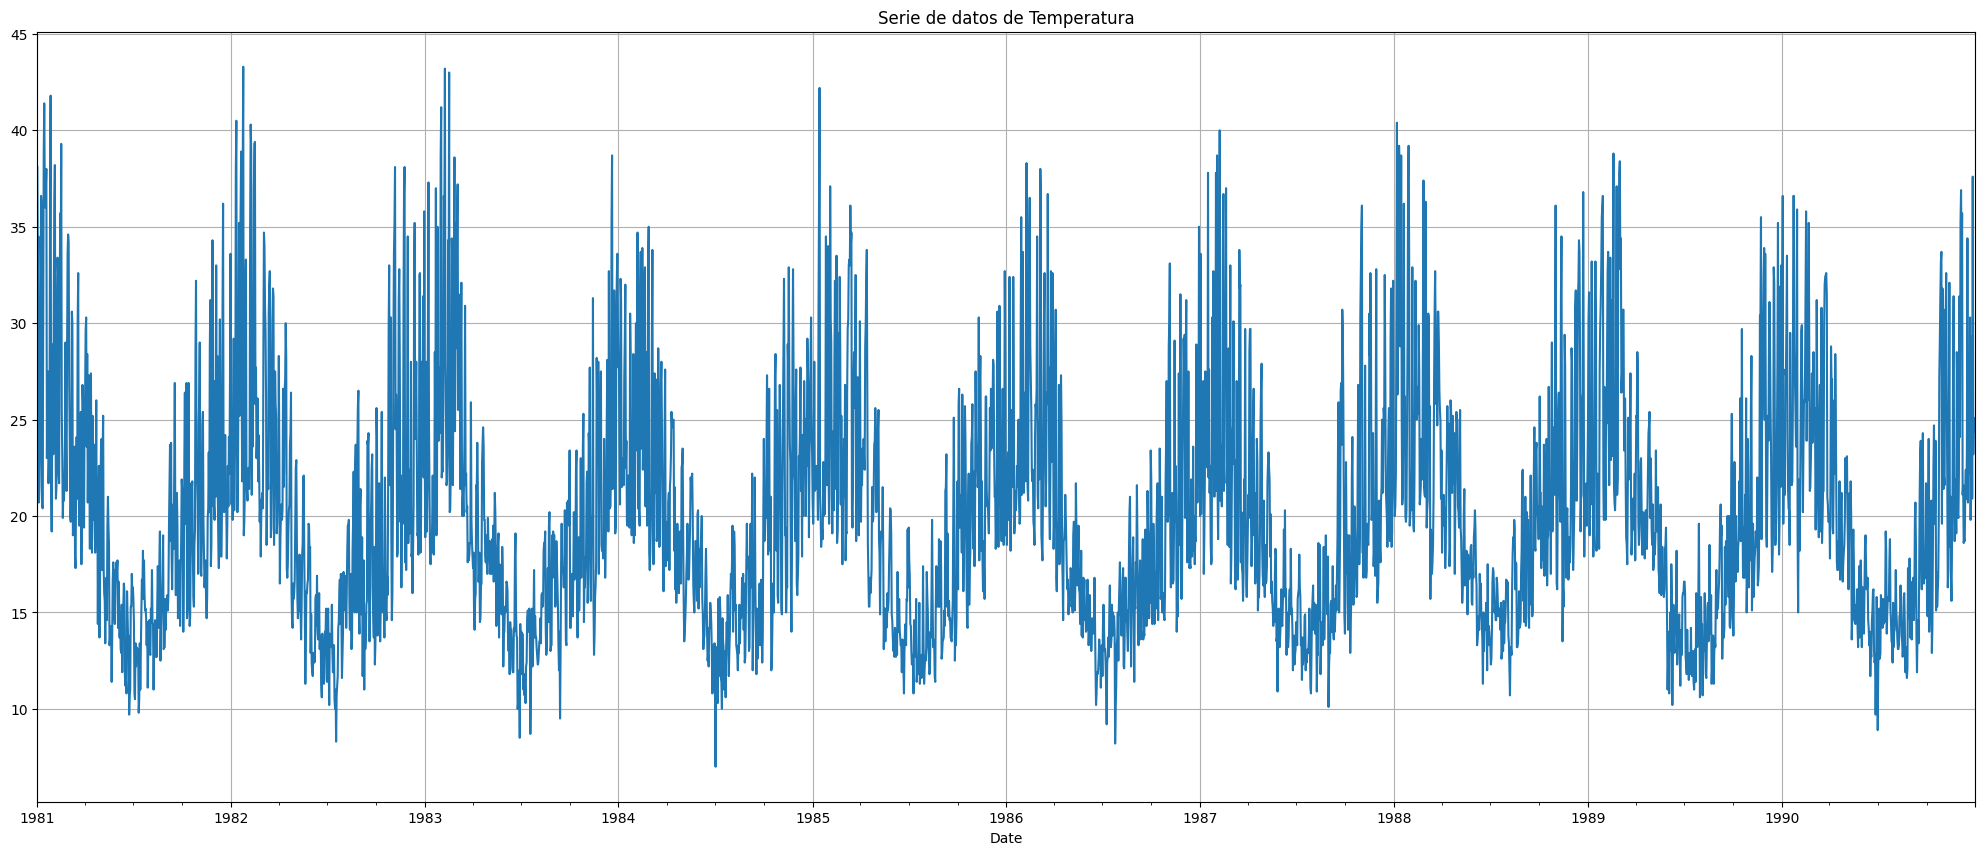

In [15]:
# Impresion de la serie
df_temperature['Temperature'].plot(title="Serie de datos de Temperatura", figsize=(25, 10))
plt.grid(True)
plt.show()

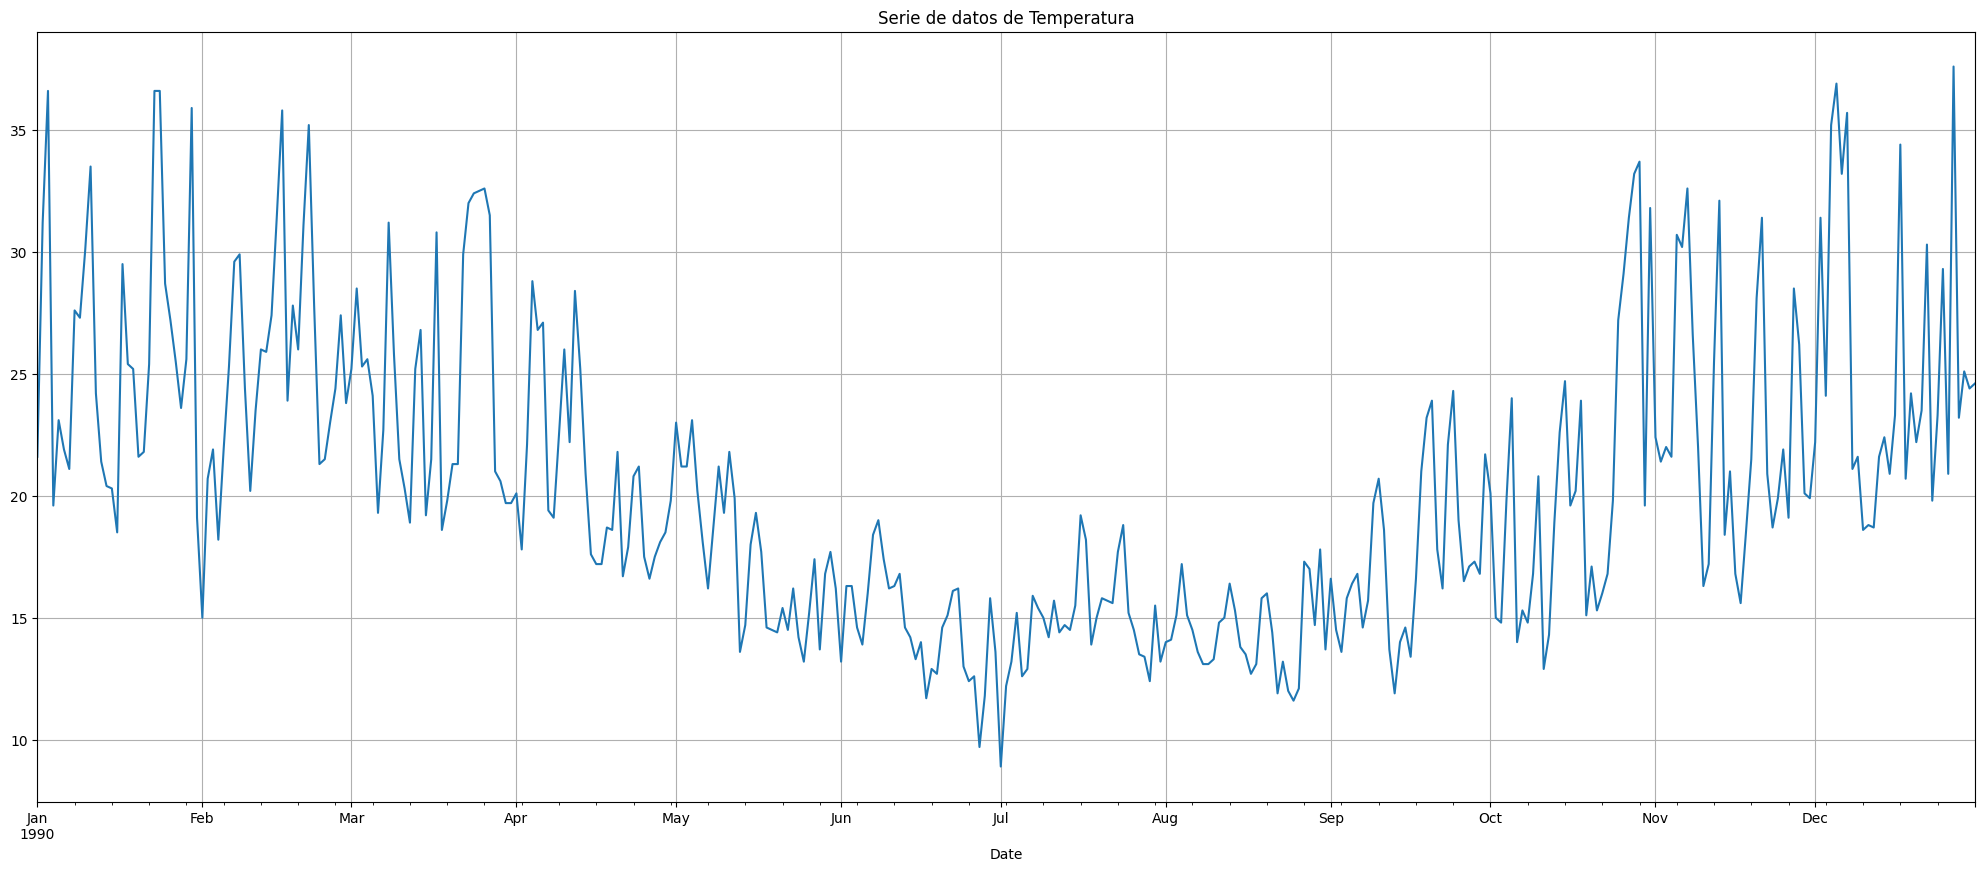

In [16]:
# Impresion del ultimo año
df_temperature['Temperature'][-365:].plot(title="Serie de datos de Temperatura", figsize=(25, 10))
plt.grid(True)
plt.show()

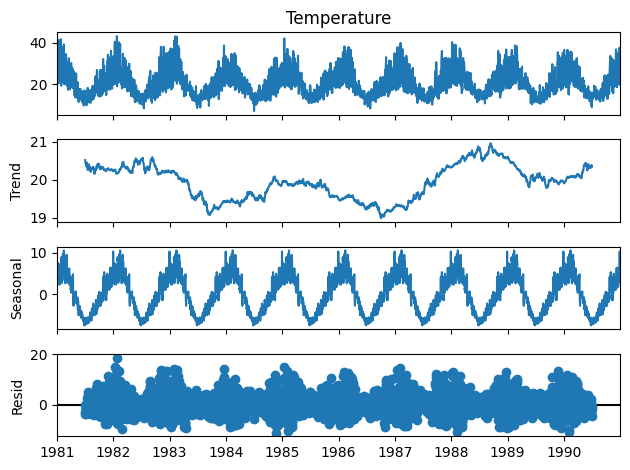

In [17]:
# Descomposicion de la serie en tendencia, estacionalidad y residuo.
decomp = seasonal_decompose(df_temperature['Temperature'], model='additive', period=365)

decomp.plot()
plt.show()

In [18]:
# Test de Deckey-Fuller para determinar si la serie es estacionaria o no. Un p-valor <0.05 indica que la serie es estacionaria
sts.adfuller(df_temperature['Temperature'])

(-4.615638689110393,
 0.00012086261924479347,
 19,
 3632,
 {'1%': -3.4321517422129952,
  '5%': -2.8623361092467525,
  '10%': -2.567193781223316},
 20166.061170099576)

## Seteo de parametros y funciones

In [19]:
# Cantidad de dias para la predicción
dias_forecast = 30

# Descomposición en conjunto de entrenamiento y conjunto de prueba
df_temperature_train = df_temperature.iloc[:-dias_forecast] 
df_temperature_test = df_temperature.iloc[-dias_forecast:]

In [20]:
# Funcion para comprar los modelos. Realiza el Test de Razón de Verosimilitud (LR Test)
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF)
    return p

In [21]:
# Calcula métricas de error comunes (MAE, MSE, RMSE) para evaluar el rendimiento de un modelo de predicción.
def evaluar_modelo(y_real, y_predicho, nombre_modelo="Modelo"):
    mae = mean_absolute_error(y_real, y_predicho)
    mse = mean_squared_error(y_real, y_predicho)
    rmse = np.sqrt(mse)
      
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse}

In [22]:
# Inicializacion de diccionarios
modelos_arima = {}
resultado_modelos_arima = {}
df_metricas = pd.DataFrame(columns=['MAE', 'MSE', 'RMSE', 'AIC'])

In [23]:
# Funcion para los modelos de Holt Winters que incluye el fit, forecast y calculo de errores. Ademas guarda en los diccionarios los datos y realiza el grafico.
def holtwinters(nombre_modelo, modelo,resultado_modelos_arima,df_temperature,df_metricas):
    
    fitted = modelo.fittedvalues.shift(-1)  
    forecast = modelo.forecast(dias_forecast)
    errores = evaluar_modelo(df_temperature_test['Temperature'], forecast, nombre_modelo=nombre_modelo)
    errores['AIC'] = 0

    df_temperature.loc[fitted.index, nombre_modelo] = fitted
    df_temperature.loc[forecast.index, nombre_modelo] = forecast
    df_metricas.loc[nombre_modelo] = errores
    
    print(df_metricas.sort_values('RMSE'))

    # Gráfico
    df_temperature_train['Temperature'].plot(legend=True, label='Serie train', figsize=(12, 6), color='b')
    df_temperature_test['Temperature'].plot(legend=True,label='Serie test', figsize=(12, 6), color='b',linestyle='--')
    fitted.plot(legend=True,label='Serie fitted', figsize=(12, 6), color='orange')
    forecast.plot(legend=True,label='Serie forecast', figsize=(12, 6), color='orange', xlim=[df_temperature_train.index[-60],df_temperature_test.index[-1]],linestyle='--')
    plt.title(f'Ajuste y pronóstico del modelo {nombre_modelo}')
    plt.show()
    
    return resultado_modelos_arima, df_temperature, df_metricas

In [24]:
# Funcion para los modelos de Arima que incluye el fit, forecast y calculo de errores. Ademas guarda en los diccionarios los datos y realiza el grafico.
def arima(nombre_modelo, modelo,resultado_modelos_arima,df_temperature,df_metricas,modelos_arima):
    
    modelos_arima[nombre_modelo] = modelo
    modelo_fit = modelo.fit()
    resultado_modelos_arima[nombre_modelo] = modelo_fit
    
    fitted = modelo_fit.fittedvalues.shift(-1)  
    forecast = modelo_fit.forecast(dias_forecast)
    errores = evaluar_modelo(df_temperature_test['Temperature'], forecast, nombre_modelo=nombre_modelo)
    errores['AIC'] = modelo_fit.aic
    
    df_temperature.loc[fitted.index, nombre_modelo] = fitted
    df_temperature.loc[forecast.index, nombre_modelo] = forecast
    df_metricas.loc[nombre_modelo] = errores
    
    print(df_metricas.sort_values('RMSE'))
    print('')
    print(modelo_fit.summary())
    print('')

    # Gráfico
    df_temperature_train['Temperature'].plot(legend=True, label='Serie train', figsize=(12, 6), color='b')
    df_temperature_test['Temperature'].plot(legend=True,label='Serie test', figsize=(12, 6), color='b',linestyle='--')
    fitted.plot(legend=True,label='Serie fitted', figsize=(12, 6), color='orange')
    forecast.plot(legend=True,label='Serie forecast', figsize=(12, 6), color='orange', xlim=[df_temperature_train.index[-60],df_temperature_test.index[-1]],linestyle='--')
    plt.title(f'Ajuste y pronóstico del modelo {nombre_modelo}')
    plt.show()
    
    return resultado_modelos_arima, df_temperature, df_metricas, modelos_arima

## Modelo de Holt-Winters

### Simple

          MAE        MSE     RMSE  AIC
SES  4.804388  48.485323  6.96314    0


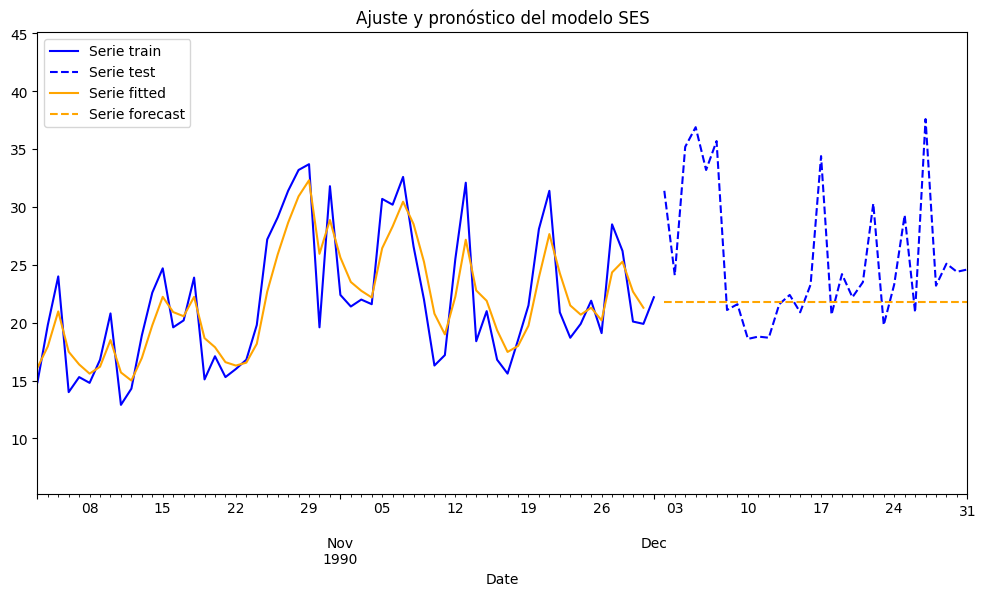

In [116]:
# Entrenamiento
modelo = SimpleExpSmoothing(df_temperature_train['Temperature']).fit(smoothing_level=0.5, optimized=False)

# Calculo de metricas
resultado_modelos_arima, df_temperature, df_errores = holtwinters('SES', modelo, resultado_modelos_arima, df_temperature, df_metricas)

### Doble

                    MAE        MSE      RMSE  AIC
DES_trend_add  4.683962  45.740642  6.763183    0
SES            4.804388  48.485323  6.963140    0


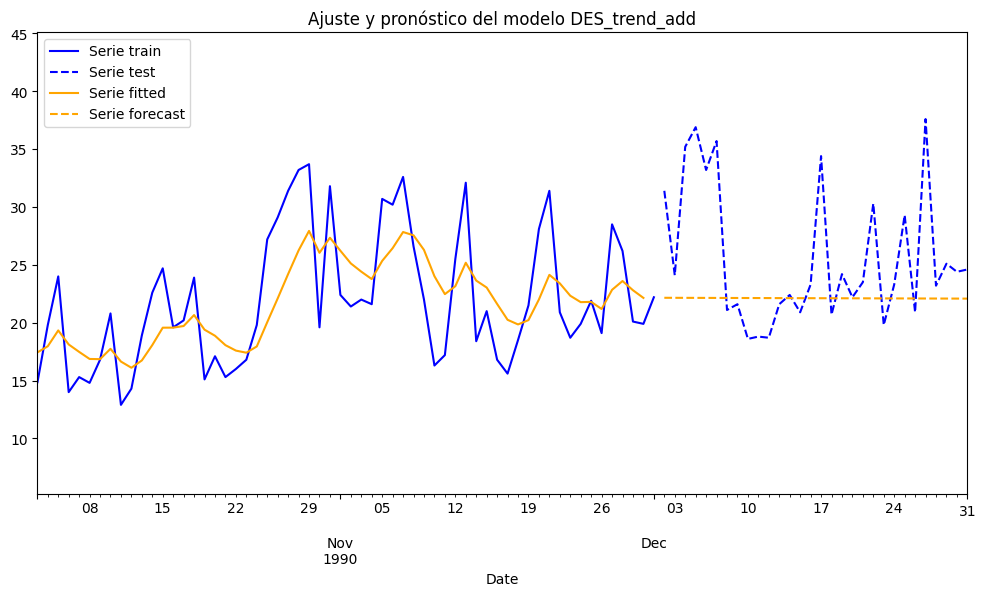

In [117]:
# Entrenamiento
modelo = ExponentialSmoothing(df_temperature_train['Temperature'], trend='add').fit()

# Calculo de metricas
resultado_modelos_arima, df_temperature, df_errores = holtwinters('DES_trend_add', modelo, resultado_modelos_arima, df_temperature, df_metricas)

c:\Users\juana\anaconda3\envs\AST\lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


                    MAE        MSE      RMSE  AIC
DES_trend_add  4.683962  45.740642  6.763183    0
SES            4.804388  48.485323  6.963140    0
DES_trend_mul  4.891813  49.127413  7.009095    0


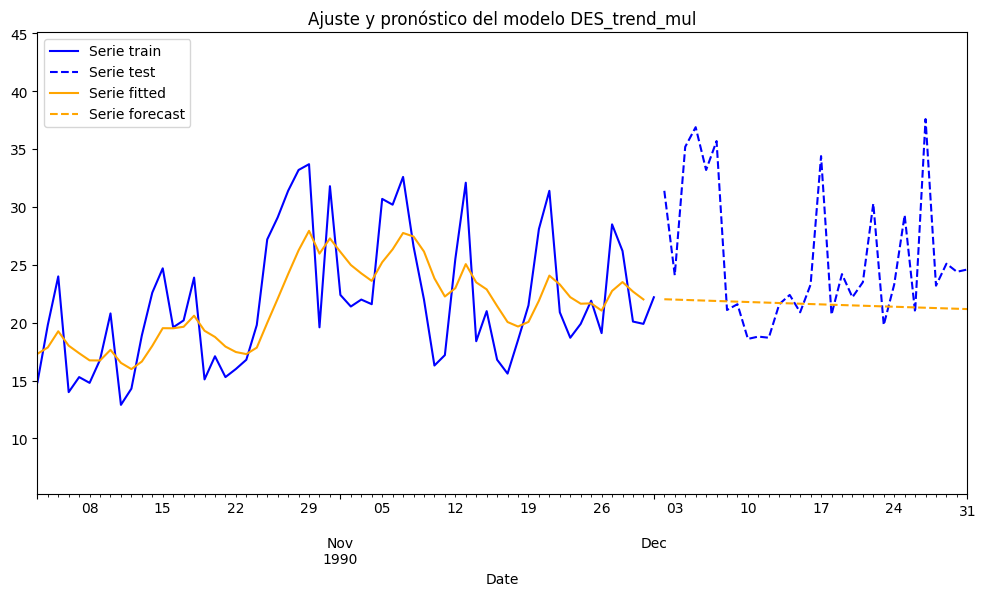

In [118]:
# Entrenamiento
modelo = ExponentialSmoothing(df_temperature_train['Temperature'], trend='mul').fit()

# Calculo de metricas
resultado_modelos_arima, df_temperature, df_errores = holtwinters('DES_trend_mul', modelo, resultado_modelos_arima, df_temperature, df_metricas)

### Triple

                                 MAE        MSE      RMSE  AIC
DES_trend_add               4.683962  45.740642  6.763183    0
TES_trend_add_seasonal_add  5.197241  48.068017  6.933110    0
SES                         4.804388  48.485323  6.963140    0
DES_trend_mul               4.891813  49.127413  7.009095    0


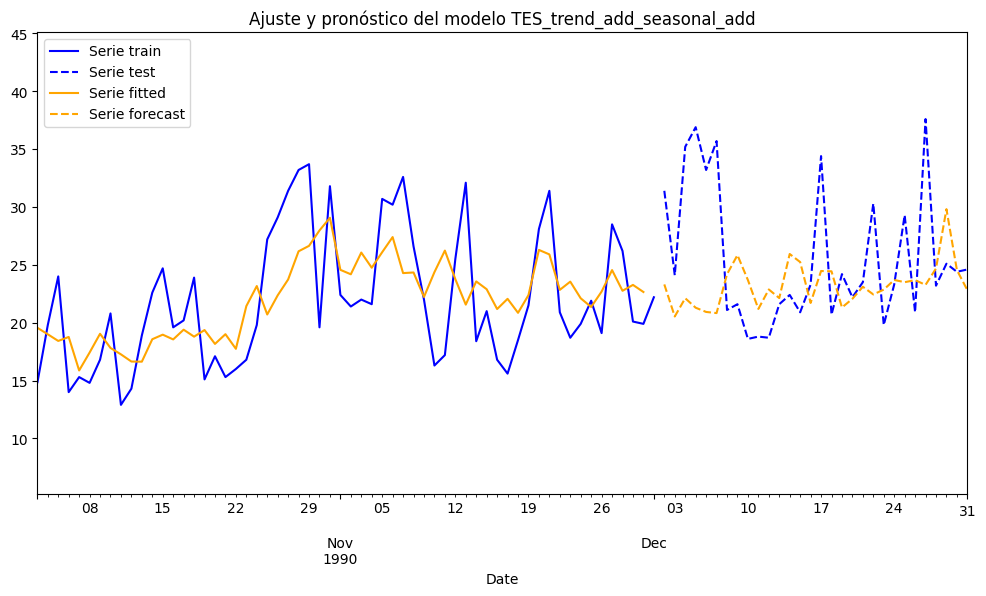

In [119]:
# Entrenamiento
modelo = ExponentialSmoothing(df_temperature_train['Temperature'], trend='add',seasonal='add',seasonal_periods=365).fit()

# Calculo de metricas
resultado_modelos_arima, df_temperature, df_errores = holtwinters('TES_trend_add_seasonal_add', modelo, resultado_modelos_arima, df_temperature, df_metricas)

c:\Users\juana\anaconda3\envs\AST\lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


                                 MAE        MSE      RMSE  AIC
DES_trend_add               4.683962  45.740642  6.763183    0
TES_trend_add_seasonal_add  5.197241  48.068017  6.933110    0
SES                         4.804388  48.485323  6.963140    0
DES_trend_mul               4.891813  49.127413  7.009095    0
TES_trend_mul_seasonal_mul  5.177283  49.981925  7.069790    0


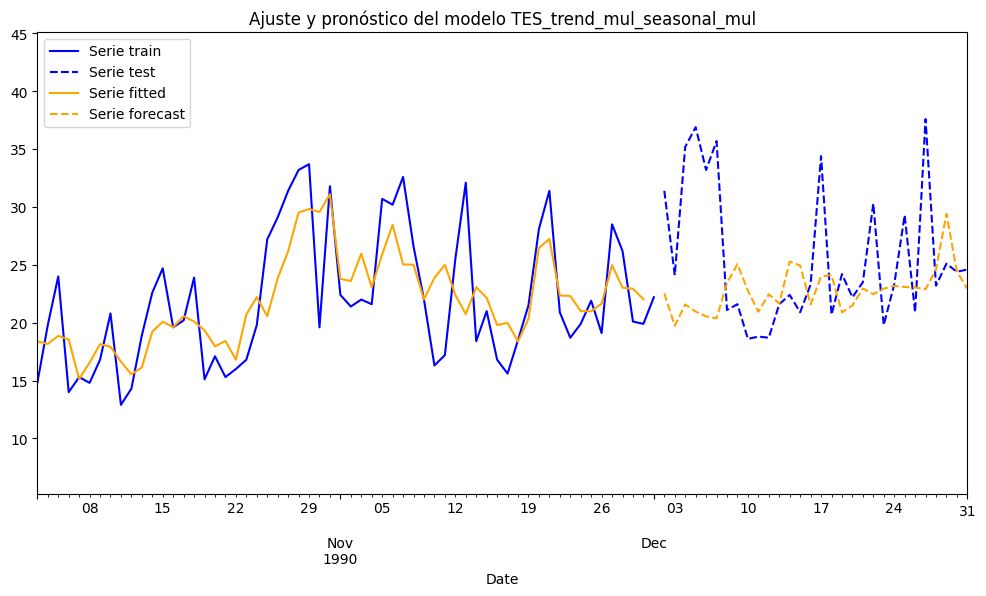

In [120]:
# Entrenamiento
modelo = ExponentialSmoothing(df_temperature_train['Temperature'], trend='mul',seasonal='mul',seasonal_periods=365).fit()

# Calculo de metricas
resultado_modelos_arima, df_temperature, df_errores = holtwinters('TES_trend_mul_seasonal_mul', modelo, resultado_modelos_arima, df_temperature, df_metricas)

## Modelo Arima

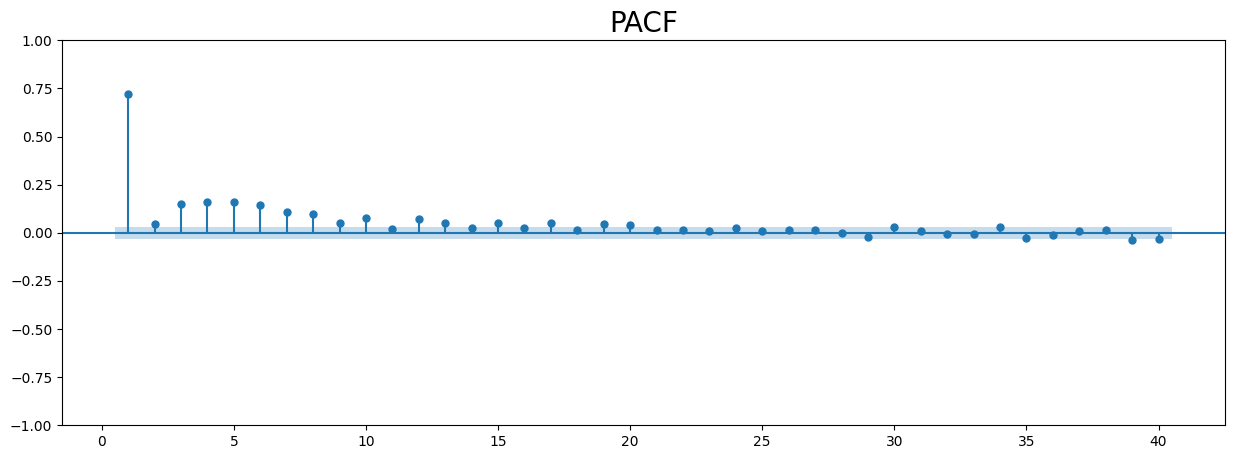

In [ ]:
# Grafica la Función de Autocorrelación Parcial (PACF) para identificar el orden del componente AR en un modelo ARIMA.
fig, ax1 = plt.subplots(figsize=(15, 5))
sgt.plot_pacf(df_temperature['Temperature'], zero = False, lags = 40, ax=ax1)
plt.title("PACF", size = 20)
plt.show()

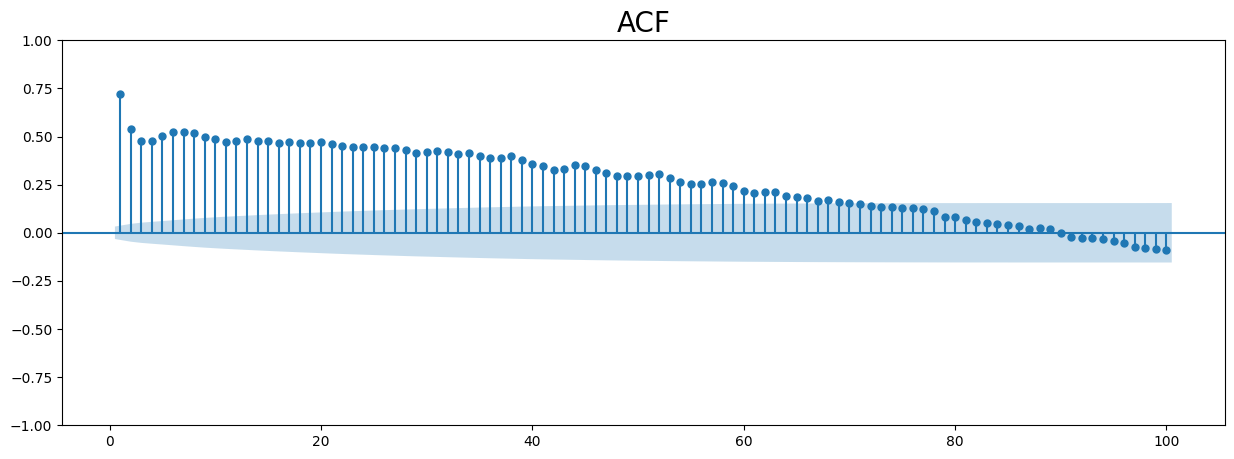

In [ ]:
# Grafica la Función de Autocorrelación (ACF) para identificar el orden del componente MA en un modelo ARIMA.
fig, ax2 = plt.subplots(figsize=(15, 5))
sgt.plot_acf(df_temperature['Temperature'], zero = False, lags = 100, ax=ax2)
plt.title("ACF", size = 20)
plt.show()

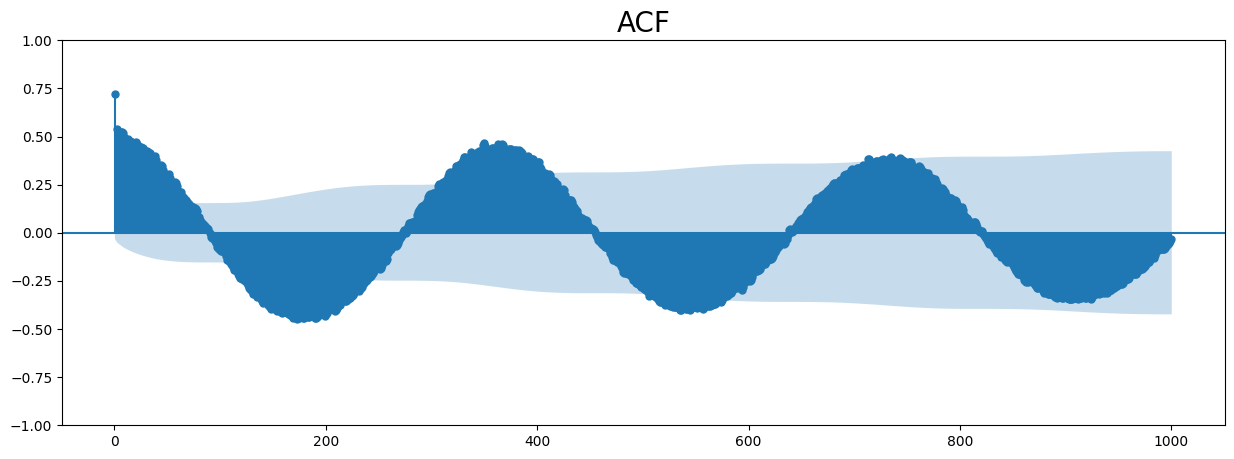

In [ ]:
# Grafica la Función de Autocorrelación (ACF) para identificar el orden del componente MA en un modelo ARIMA.
fig, ax2 = plt.subplots(figsize=(15, 5))
sgt.plot_acf(df_temperature['Temperature'], zero = False, lags = 1000, ax=ax2)
plt.title("ACF", size = 20)
plt.show()

                                 MAE        MSE      RMSE           AIC
DES_trend_add               4.683962  45.740642  6.763183      0.000000
TES_trend_add_seasonal_add  5.197241  48.068017  6.933110      0.000000
SES                         4.804388  48.485323  6.963140      0.000000
DES_trend_mul               4.891813  49.127413  7.009095      0.000000
TES_trend_mul_seasonal_mul  5.177283  49.981925  7.069790      0.000000
arima_1_0_0                 5.679291  61.434793  7.838035  20688.210566

                               SARIMAX Results                                
Dep. Variable:            Temperature   No. Observations:                 3622
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -10341.105
Date:                Wed, 23 Apr 2025   AIC                          20688.211
Time:                        19:47:33   BIC                          20706.795
Sample:                    01-01-1981   HQIC                         20694.832
                     

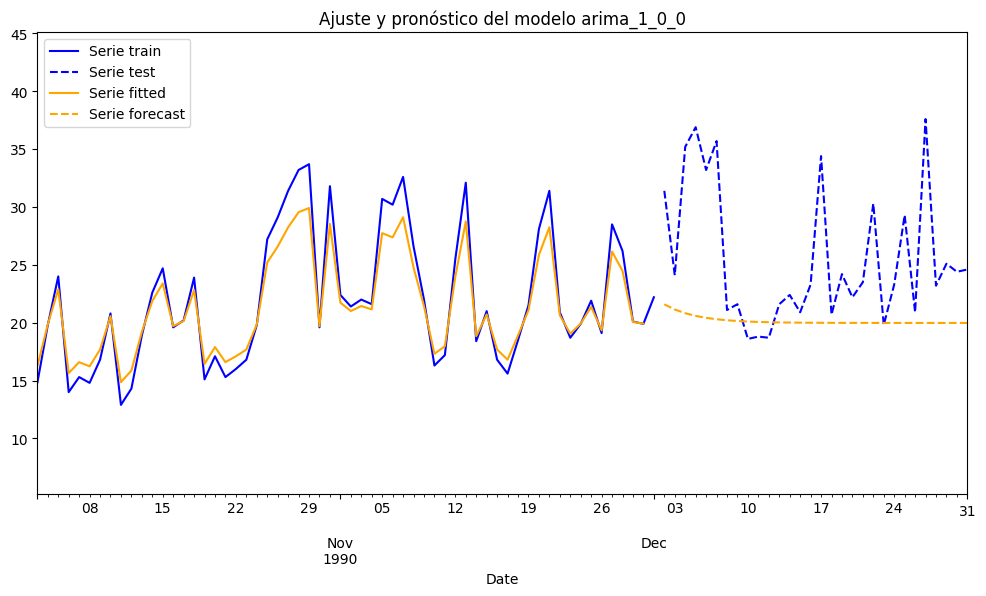

In [123]:
# Modelo
modelo = ARIMA(df_temperature_train['Temperature'], order=(1,0,0))

# Calculo de metricas
resultado_modelos_arima, df_temperature, df_errores , modelos_arima = arima('arima_1_0_0', modelo, resultado_modelos_arima, df_temperature, df_metricas, modelos_arima)

                                 MAE        MSE      RMSE           AIC
DES_trend_add               4.683962  45.740642  6.763183      0.000000
TES_trend_add_seasonal_add  5.197241  48.068017  6.933110      0.000000
SES                         4.804388  48.485323  6.963140      0.000000
DES_trend_mul               4.891813  49.127413  7.009095      0.000000
TES_trend_mul_seasonal_mul  5.177283  49.981925  7.069790      0.000000
arima_2_0_0                 5.673183  61.302760  7.829608  20684.713307
arima_1_0_0                 5.679291  61.434793  7.838035  20688.210566

                               SARIMAX Results                                
Dep. Variable:            Temperature   No. Observations:                 3622
Model:                 ARIMA(2, 0, 0)   Log Likelihood              -10338.357
Date:                Wed, 23 Apr 2025   AIC                          20684.713
Time:                        19:47:34   BIC                          20709.492
Sample:                    0

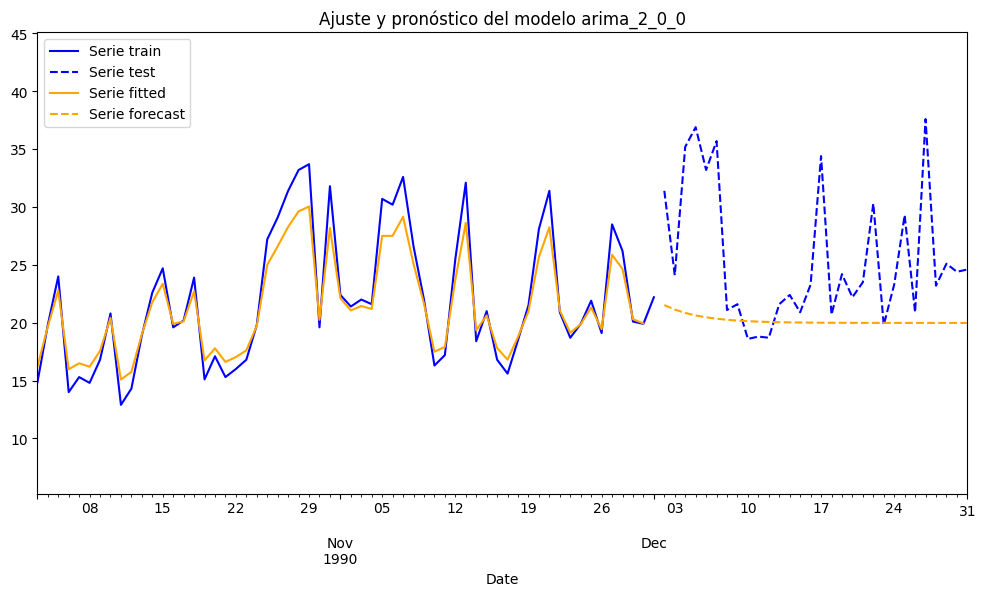

LLR_test =  0.01904630501420447


In [124]:
modelo = ARIMA(df_temperature_train['Temperature'], order=(2,0,0))

# Calculo de metricas
resultado_modelos_arima, df_temperature, df_errores , modelos_arima = arima('arima_2_0_0', modelo, resultado_modelos_arima, df_temperature, df_metricas, modelos_arima)

print('LLR_test = ',LLR_test(modelos_arima['arima_1_0_0'], modelos_arima['arima_2_0_0'], DF=1))

                                 MAE        MSE      RMSE           AIC
DES_trend_add               4.683962  45.740642  6.763183      0.000000
TES_trend_add_seasonal_add  5.197241  48.068017  6.933110      0.000000
SES                         4.804388  48.485323  6.963140      0.000000
DES_trend_mul               4.891813  49.127413  7.009095      0.000000
TES_trend_mul_seasonal_mul  5.177283  49.981925  7.069790      0.000000
arima_5_0_0                 5.205321  54.500028  7.382413  20412.400308
arima_2_0_0                 5.673183  61.302760  7.829608  20684.713307
arima_1_0_0                 5.679291  61.434793  7.838035  20688.210566

                               SARIMAX Results                                
Dep. Variable:            Temperature   No. Observations:                 3622
Model:                 ARIMA(5, 0, 0)   Log Likelihood              -10199.200
Date:                Wed, 23 Apr 2025   AIC                          20412.400
Time:                        19:47:

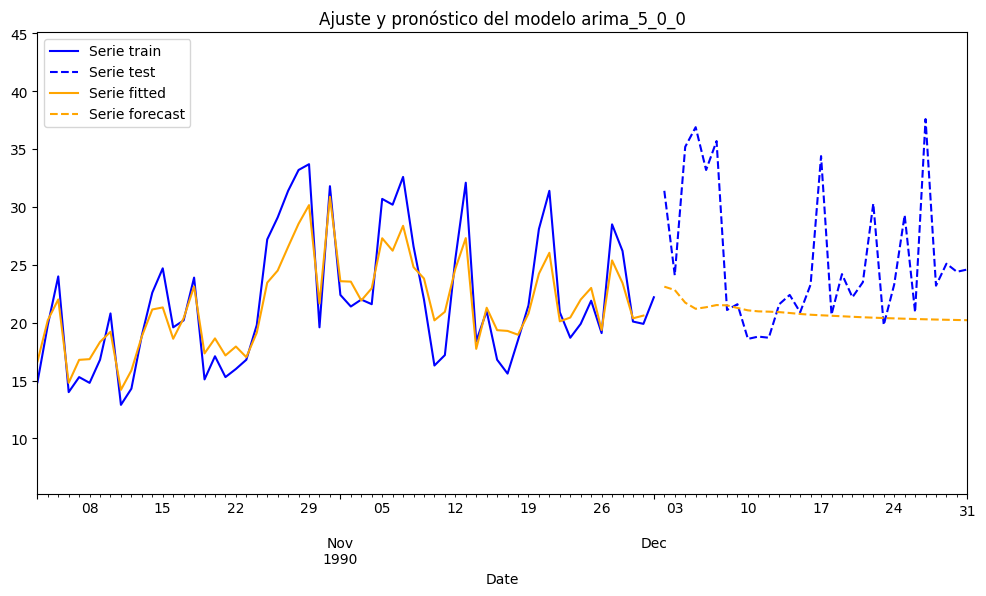

LLR_test =  4.9074876445575307e-60


In [125]:
modelo = ARIMA(df_temperature_train['Temperature'], order=(5,0,0))

# Calculo de metricas
resultado_modelos_arima, df_temperature, df_errores , modelos_arima = arima('arima_5_0_0', modelo, resultado_modelos_arima, df_temperature, df_metricas, modelos_arima)

print('LLR_test = ',LLR_test(modelos_arima['arima_2_0_0'], modelos_arima['arima_5_0_0'], DF=3))

                                 MAE        MSE      RMSE           AIC
DES_trend_add               4.683962  45.740642  6.763183      0.000000
TES_trend_add_seasonal_add  5.197241  48.068017  6.933110      0.000000
SES                         4.804388  48.485323  6.963140      0.000000
DES_trend_mul               4.891813  49.127413  7.009095      0.000000
arima_10_0_0                4.902778  49.214503  7.015305  20231.295250
TES_trend_mul_seasonal_mul  5.177283  49.981925  7.069790      0.000000
arima_5_0_0                 5.205321  54.500028  7.382413  20412.400308
arima_2_0_0                 5.673183  61.302760  7.829608  20684.713307
arima_1_0_0                 5.679291  61.434793  7.838035  20688.210566

                               SARIMAX Results                                
Dep. Variable:            Temperature   No. Observations:                 3622
Model:                ARIMA(10, 0, 0)   Log Likelihood              -10103.648
Date:                Wed, 23 Apr 2025   AI

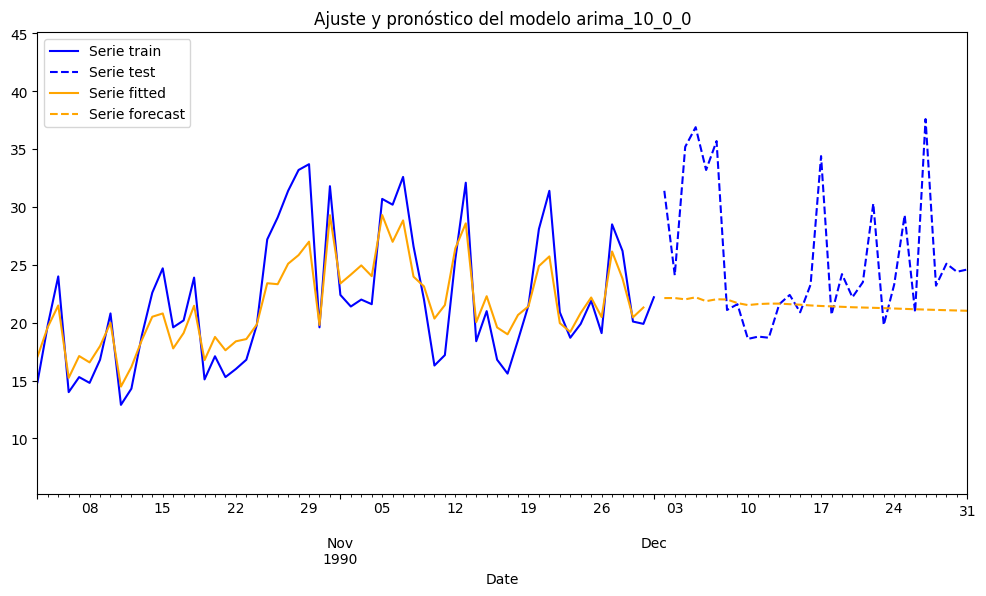

LLR_test =  2.2677256663649413e-39


In [126]:
modelo = ARIMA(df_temperature_train['Temperature'], order=(10,0,0))

# Calculo de metricas
resultado_modelos_arima, df_temperature, df_errores , modelos_arima = arima('arima_10_0_0', modelo, resultado_modelos_arima, df_temperature, df_metricas, modelos_arima)

print('LLR_test = ',LLR_test(modelos_arima['arima_5_0_0'], modelos_arima['arima_10_0_0'], DF=5))

                                 MAE        MSE      RMSE           AIC
DES_trend_add               4.683962  45.740642  6.763183      0.000000
TES_trend_add_seasonal_add  5.197241  48.068017  6.933110      0.000000
SES                         4.804388  48.485323  6.963140      0.000000
DES_trend_mul               4.891813  49.127413  7.009095      0.000000
arima_10_0_0                4.902778  49.214503  7.015305  20231.295250
arima_8_0_0                 4.917738  49.596678  7.042491  20256.629719
TES_trend_mul_seasonal_mul  5.177283  49.981925  7.069790      0.000000
arima_5_0_0                 5.205321  54.500028  7.382413  20412.400308
arima_2_0_0                 5.673183  61.302760  7.829608  20684.713307
arima_1_0_0                 5.679291  61.434793  7.838035  20688.210566

                               SARIMAX Results                                
Dep. Variable:            Temperature   No. Observations:                 3622
Model:                 ARIMA(8, 0, 0)   Log Likel

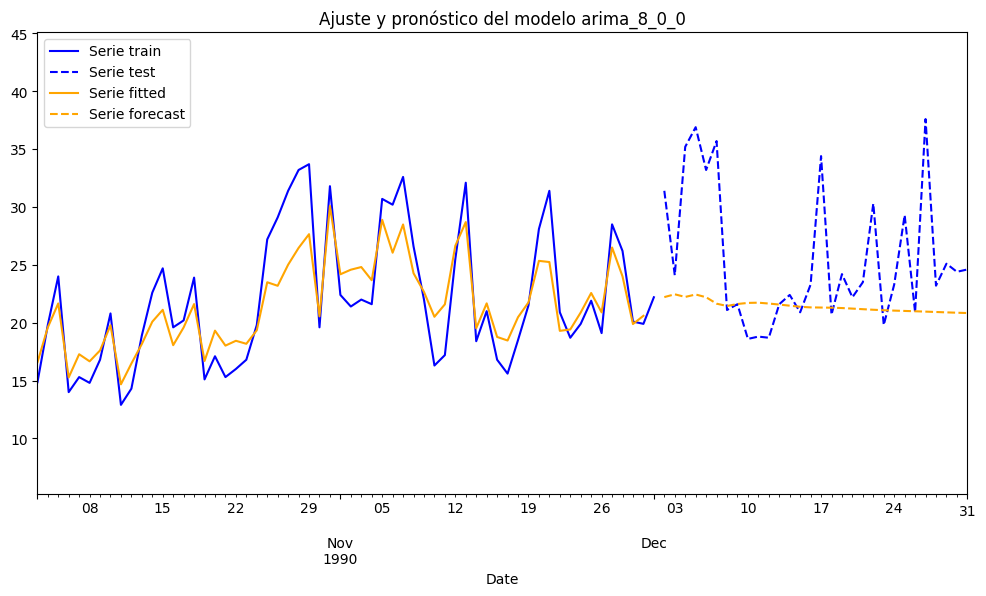

LLR_test =  4.2667874462713473e-07


In [127]:
modelo = ARIMA(df_temperature_train['Temperature'], order=(8,0,0))

# Calculo de metricas
resultado_modelos_arima, df_temperature, df_errores , modelos_arima = arima('arima_8_0_0', modelo, resultado_modelos_arima, df_temperature, df_metricas, modelos_arima)

print('LLR_test = ',LLR_test(modelos_arima['arima_8_0_0'], modelos_arima['arima_10_0_0'], DF=2))

                                 MAE        MSE      RMSE           AIC
DES_trend_add               4.683962  45.740642  6.763183      0.000000
TES_trend_add_seasonal_add  5.197241  48.068017  6.933110      0.000000
SES                         4.804388  48.485323  6.963140      0.000000
DES_trend_mul               4.891813  49.127413  7.009095      0.000000
arima_10_0_0                4.902778  49.214503  7.015305  20231.295250
arima_9_0_0                 4.902873  49.280944  7.020039  20247.687644
arima_8_0_0                 4.917738  49.596678  7.042491  20256.629719
TES_trend_mul_seasonal_mul  5.177283  49.981925  7.069790      0.000000
arima_5_0_0                 5.205321  54.500028  7.382413  20412.400308
arima_2_0_0                 5.673183  61.302760  7.829608  20684.713307
arima_1_0_0                 5.679291  61.434793  7.838035  20688.210566

                               SARIMAX Results                                
Dep. Variable:            Temperature   No. Observations

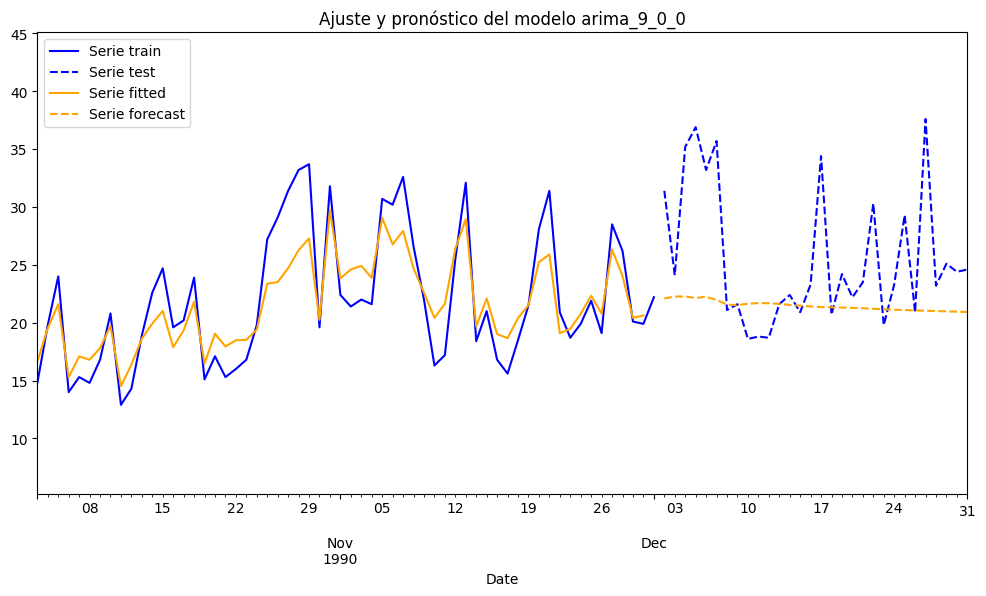

LLR_test =  1.7977411228341565e-05


In [128]:
modelo = ARIMA(df_temperature_train['Temperature'], order=(9,0,0))

# Calculo de metricas
resultado_modelos_arima, df_temperature, df_errores , modelos_arima = arima('arima_9_0_0', modelo, resultado_modelos_arima, df_temperature, df_metricas, modelos_arima)

print('LLR_test = ',LLR_test(modelos_arima['arima_9_0_0'], modelos_arima['arima_10_0_0'], DF=1))

                                 MAE        MSE      RMSE           AIC
arima_9_0_1                 4.665373  45.056665  6.712426  20172.949239
DES_trend_add               4.683962  45.740642  6.763183      0.000000
TES_trend_add_seasonal_add  5.197241  48.068017  6.933110      0.000000
SES                         4.804388  48.485323  6.963140      0.000000
DES_trend_mul               4.891813  49.127413  7.009095      0.000000
arima_10_0_0                4.902778  49.214503  7.015305  20231.295250
arima_9_0_0                 4.902873  49.280944  7.020039  20247.687644
arima_8_0_0                 4.917738  49.596678  7.042491  20256.629719
TES_trend_mul_seasonal_mul  5.177283  49.981925  7.069790      0.000000
arima_5_0_0                 5.205321  54.500028  7.382413  20412.400308
arima_2_0_0                 5.673183  61.302760  7.829608  20684.713307
arima_1_0_0                 5.679291  61.434793  7.838035  20688.210566

                               SARIMAX Results                 

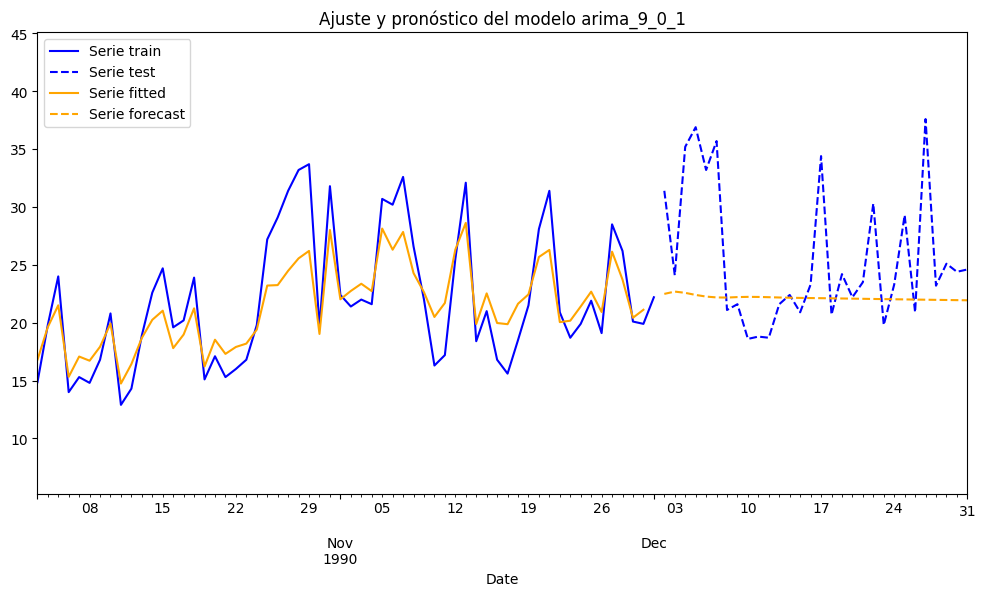

LLR_test =  1.9517077471185833e-18


In [129]:
modelo = ARIMA(df_temperature_train['Temperature'], order=(9,0,1))

# Calculo de metricas
resultado_modelos_arima, df_temperature, df_errores , modelos_arima = arima('arima_9_0_1', modelo, resultado_modelos_arima, df_temperature, df_metricas, modelos_arima)

print('LLR_test = ',LLR_test(modelos_arima['arima_9_0_0'], modelos_arima['arima_9_0_1'], DF=1))

                                 MAE        MSE      RMSE           AIC
arima_9_0_1                 4.665373  45.056665  6.712426  20172.949239
arima_6_0_1                 4.676129  45.242637  6.726265  20169.003774
DES_trend_add               4.683962  45.740642  6.763183      0.000000
TES_trend_add_seasonal_add  5.197241  48.068017  6.933110      0.000000
SES                         4.804388  48.485323  6.963140      0.000000
DES_trend_mul               4.891813  49.127413  7.009095      0.000000
arima_10_0_0                4.902778  49.214503  7.015305  20231.295250
arima_9_0_0                 4.902873  49.280944  7.020039  20247.687644
arima_8_0_0                 4.917738  49.596678  7.042491  20256.629719
TES_trend_mul_seasonal_mul  5.177283  49.981925  7.069790      0.000000
arima_5_0_0                 5.205321  54.500028  7.382413  20412.400308
arima_2_0_0                 5.673183  61.302760  7.829608  20684.713307
arima_1_0_0                 5.679291  61.434793  7.838035  20688

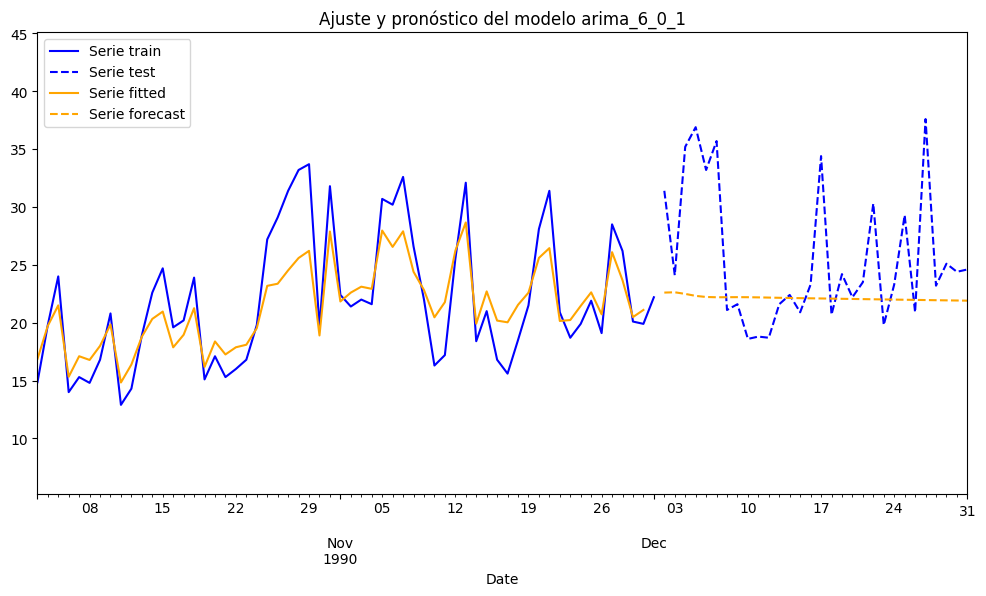

LLR_test =  0.5611651802293509


In [130]:
modelo = ARIMA(df_temperature_train['Temperature'], order=(6,0,1))

# Calculo de metricas
resultado_modelos_arima, df_temperature, df_errores , modelos_arima = arima('arima_6_0_1', modelo, resultado_modelos_arima, df_temperature, df_metricas, modelos_arima)

print('LLR_test = ',LLR_test(modelos_arima['arima_6_0_1'], modelos_arima['arima_9_0_1'], DF=3))

                                 MAE        MSE      RMSE           AIC
arima_9_0_1                 4.665373  45.056665  6.712426  20172.949239
arima_5_0_1                 4.672715  45.199095  6.723027  20167.102862
arima_6_0_1                 4.676129  45.242637  6.726265  20169.003774
DES_trend_add               4.683962  45.740642  6.763183      0.000000
TES_trend_add_seasonal_add  5.197241  48.068017  6.933110      0.000000
SES                         4.804388  48.485323  6.963140      0.000000
DES_trend_mul               4.891813  49.127413  7.009095      0.000000
arima_10_0_0                4.902778  49.214503  7.015305  20231.295250
arima_9_0_0                 4.902873  49.280944  7.020039  20247.687644
arima_8_0_0                 4.917738  49.596678  7.042491  20256.629719
TES_trend_mul_seasonal_mul  5.177283  49.981925  7.069790      0.000000
arima_5_0_0                 5.205321  54.500028  7.382413  20412.400308
arima_2_0_0                 5.673183  61.302760  7.829608  20684

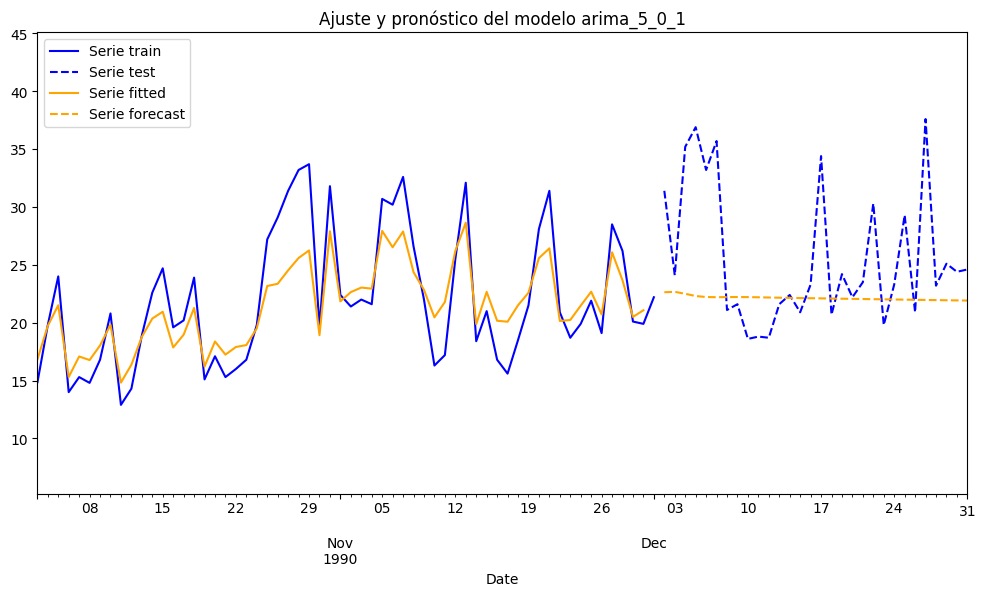

LLR_test =  0.7529267823754477


In [131]:
modelo = ARIMA(df_temperature_train['Temperature'], order=(5,0,1))

# Calculo de metricas
resultado_modelos_arima, df_temperature, df_errores , modelos_arima = arima('arima_5_0_1', modelo, resultado_modelos_arima, df_temperature, df_metricas, modelos_arima)

print('LLR_test = ',LLR_test(modelos_arima['arima_5_0_1'], modelos_arima['arima_6_0_1'], DF=1))

                                 MAE        MSE      RMSE           AIC
arima_9_0_1                 4.665373  45.056665  6.712426  20172.949239
arima_4_0_1                 4.665003  45.094895  6.715273  20168.342272
arima_5_0_1                 4.672715  45.199095  6.723027  20167.102862
arima_6_0_1                 4.676129  45.242637  6.726265  20169.003774
DES_trend_add               4.683962  45.740642  6.763183      0.000000
TES_trend_add_seasonal_add  5.197241  48.068017  6.933110      0.000000
SES                         4.804388  48.485323  6.963140      0.000000
DES_trend_mul               4.891813  49.127413  7.009095      0.000000
arima_10_0_0                4.902778  49.214503  7.015305  20231.295250
arima_9_0_0                 4.902873  49.280944  7.020039  20247.687644
arima_8_0_0                 4.917738  49.596678  7.042491  20256.629719
TES_trend_mul_seasonal_mul  5.177283  49.981925  7.069790      0.000000
arima_5_0_0                 5.205321  54.500028  7.382413  20412

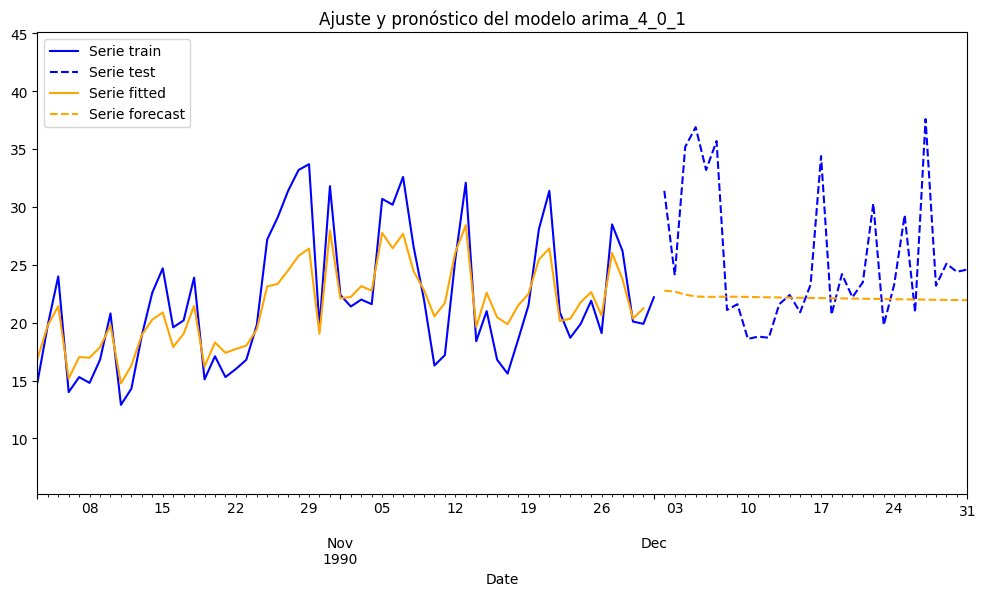

LLR_test =  0.0718865503099359


In [132]:
modelo = ARIMA(df_temperature_train['Temperature'], order=(4,0,1))

# Calculo de metricas
resultado_modelos_arima, df_temperature, df_errores , modelos_arima = arima('arima_4_0_1', modelo, resultado_modelos_arima, df_temperature, df_metricas, modelos_arima)

print('LLR_test = ',LLR_test(modelos_arima['arima_4_0_1'], modelos_arima['arima_5_0_1'], DF=1))

c:\Users\juana\anaconda3\envs\AST\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\juana\anaconda3\envs\AST\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\juana\anaconda3\envs\AST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                 MAE        MSE      RMSE           AIC
arima_4_0_2                 4.637731  44.650831  6.682128  20177.365070
arima_9_0_1                 4.665373  45.056665  6.712426  20172.949239
arima_4_0_1                 4.665003  45.094895  6.715273  20168.342272
arima_5_0_1                 4.672715  45.199095  6.723027  20167.102862
arima_6_0_1                 4.676129  45.242637  6.726265  20169.003774
DES_trend_add               4.683962  45.740642  6.763183      0.000000
TES_trend_add_seasonal_add  5.197241  48.068017  6.933110      0.000000
SES                         4.804388  48.485323  6.963140      0.000000
DES_trend_mul               4.891813  49.127413  7.009095      0.000000
arima_10_0_0                4.902778  49.214503  7.015305  20231.295250
arima_9_0_0                 4.902873  49.280944  7.020039  20247.687644
arima_8_0_0                 4.917738  49.596678  7.042491  20256.629719
TES_trend_mul_seasonal_mul  5.177283  49.981925  7.069790      0

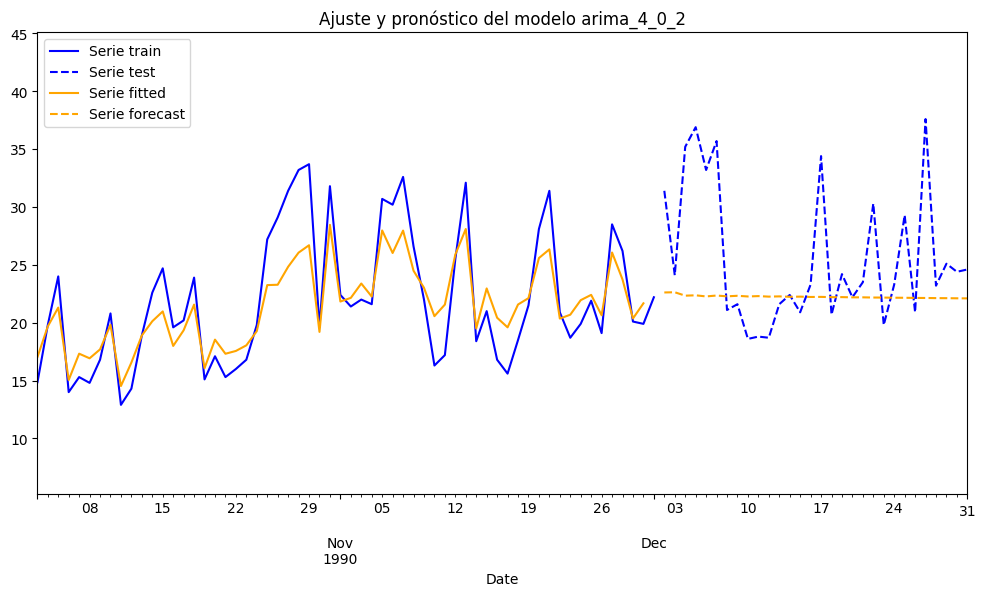

c:\Users\juana\anaconda3\envs\AST\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\juana\anaconda3\envs\AST\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


LLR_test =  1.0


c:\Users\juana\anaconda3\envs\AST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [133]:
modelo = ARIMA(df_temperature_train['Temperature'], order=(4,0,2))

# Calculo de metricas
resultado_modelos_arima, df_temperature, df_errores , modelos_arima = arima('arima_4_0_2', modelo, resultado_modelos_arima, df_temperature, df_metricas, modelos_arima)

print('LLR_test = ',LLR_test(modelos_arima['arima_4_0_1'], modelos_arima['arima_4_0_2'], DF=1))

                                 MAE        MSE      RMSE           AIC
arima_4_0_2                 4.637731  44.650831  6.682128  20177.365070
arima_9_0_1                 4.665373  45.056665  6.712426  20172.949239
arima_4_0_1                 4.665003  45.094895  6.715273  20168.342272
arima_3_0_1                 4.672088  45.174594  6.721205  20176.873892
arima_5_0_1                 4.672715  45.199095  6.723027  20167.102862
arima_6_0_1                 4.676129  45.242637  6.726265  20169.003774
DES_trend_add               4.683962  45.740642  6.763183      0.000000
TES_trend_add_seasonal_add  5.197241  48.068017  6.933110      0.000000
SES                         4.804388  48.485323  6.963140      0.000000
DES_trend_mul               4.891813  49.127413  7.009095      0.000000
arima_10_0_0                4.902778  49.214503  7.015305  20231.295250
arima_9_0_0                 4.902873  49.280944  7.020039  20247.687644
arima_8_0_0                 4.917738  49.596678  7.042491  20256

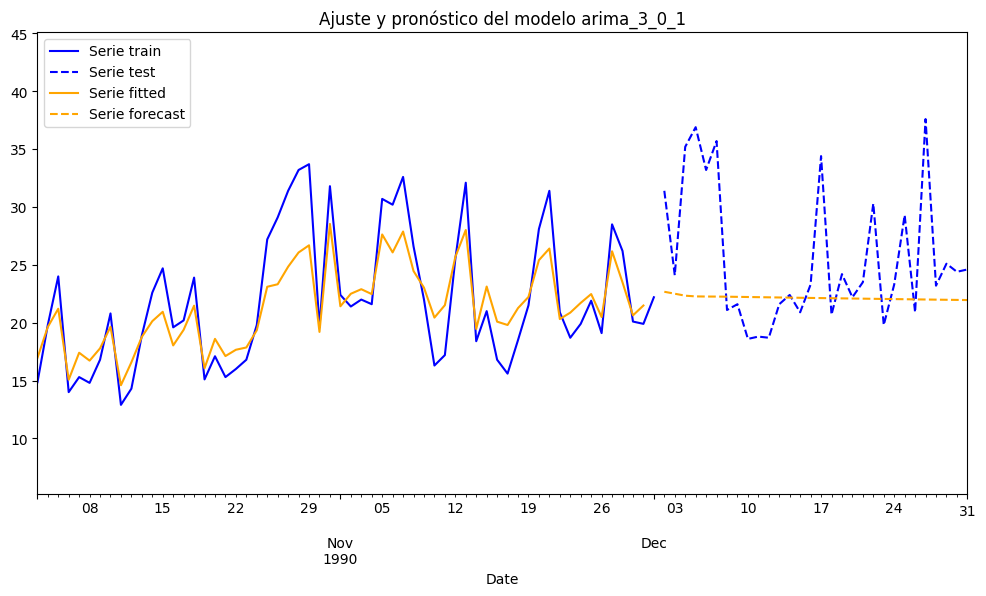

LLR_test =  0.001173492928127458


In [134]:
modelo = ARIMA(df_temperature_train['Temperature'], order=(3,0,1))

# Calculo de metricas
resultado_modelos_arima, df_temperature, df_errores , modelos_arima = arima('arima_3_0_1', modelo, resultado_modelos_arima, df_temperature, df_metricas, modelos_arima)

print('LLR_test = ',LLR_test(modelos_arima['arima_3_0_1'], modelos_arima['arima_4_0_1'], DF=1))

c:\Users\juana\anaconda3\envs\AST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                 MAE        MSE      RMSE           AIC
arima_4_0_2                 4.637731  44.650831  6.682128  20177.365070
arima_4_0_4                 4.649368  44.737235  6.688590  20169.256536
arima_9_0_1                 4.665373  45.056665  6.712426  20172.949239
arima_4_0_1                 4.665003  45.094895  6.715273  20168.342272
arima_3_0_1                 4.672088  45.174594  6.721205  20176.873892
arima_5_0_1                 4.672715  45.199095  6.723027  20167.102862
arima_6_0_1                 4.676129  45.242637  6.726265  20169.003774
DES_trend_add               4.683962  45.740642  6.763183      0.000000
TES_trend_add_seasonal_add  5.197241  48.068017  6.933110      0.000000
SES                         4.804388  48.485323  6.963140      0.000000
DES_trend_mul               4.891813  49.127413  7.009095      0.000000
arima_10_0_0                4.902778  49.214503  7.015305  20231.295250
arima_9_0_0                 4.902873  49.280944  7.020039  20247

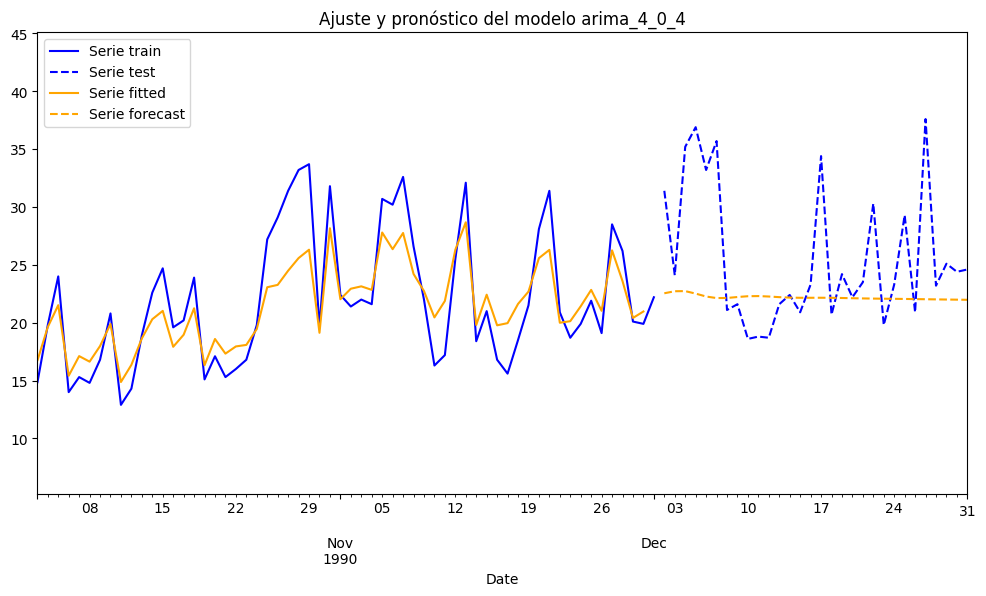

LLR_test =  0.16562577029199027


c:\Users\juana\anaconda3\envs\AST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [135]:
modelo = ARIMA(df_temperature_train['Temperature'], order=(4,0,4))

# Calculo de metricas
resultado_modelos_arima, df_temperature, df_errores , modelos_arima = arima('arima_4_0_4', modelo, resultado_modelos_arima, df_temperature, df_metricas, modelos_arima)

print('LLR_test = ',LLR_test(modelos_arima['arima_4_0_1'], modelos_arima['arima_4_0_4'], DF=3))

<Axes: xlabel='Date'>

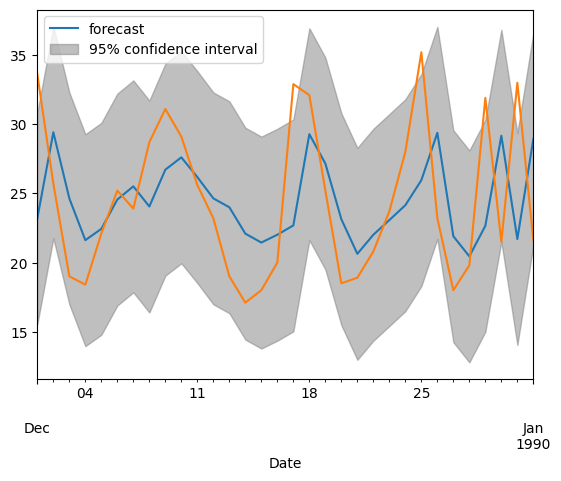

In [136]:
plot_predict(resultado_modelos_arima['arima_4_0_1'], start='1989-12-01', end = '1990-01-01')
serie_temperature['1989-12-01':'1990-01-01'].plot()

## Modelo Sarima

                                 MAE        MSE      RMSE           AIC
sarimax_4_0_1_1_0_1_7       4.592276  43.779784  6.616629  20185.150433
sarimax_4_0_1_1_1_1_45      4.728953  44.509959  6.671578  20113.491596
sarimax_4_0_1_1_1_1_30      4.664762  44.636253  6.681037  20130.978832
arima_4_0_2                 4.637731  44.650831  6.682128  20177.365070
sarimax_4_0_1_1_1_1_7       4.639112  44.715874  6.686993  20175.635844
arima_4_0_4                 4.649368  44.737235  6.688590  20169.256536
sarimax_4_0_1_1_1_1_15      4.667874  44.843014  6.696493  20157.747900
arima_9_0_1                 4.665373  45.056665  6.712426  20172.949239
arima_4_0_1                 4.665003  45.094895  6.715273  20168.342272
arima_3_0_1                 4.672088  45.174594  6.721205  20176.873892
arima_5_0_1                 4.672715  45.199095  6.723027  20167.102862
arima_6_0_1                 4.676129  45.242637  6.726265  20169.003774
sarimax_4_0_1_1_1_1_60      4.709222  45.335294  6.733149  20067

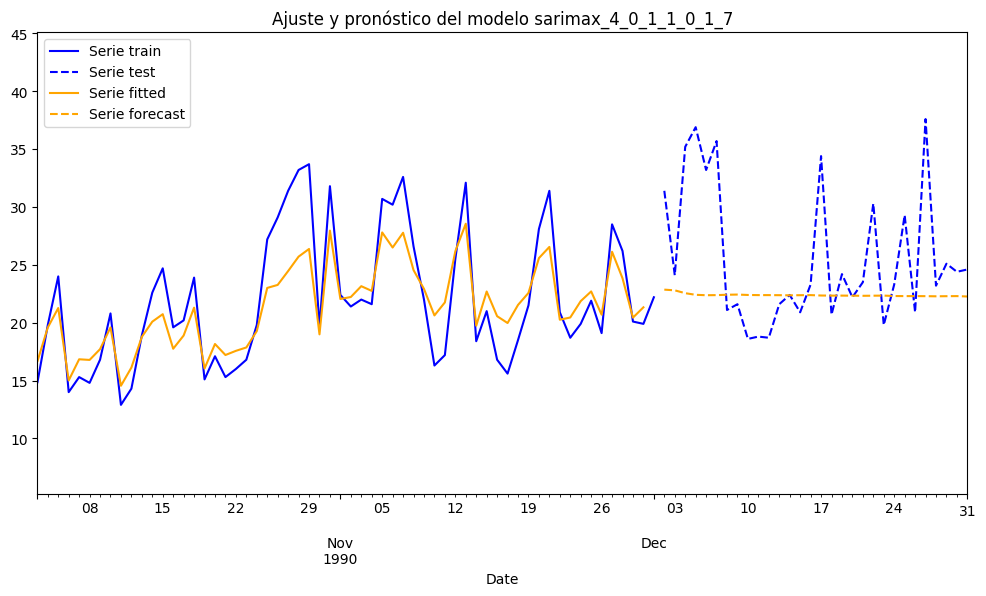

In [142]:
modelo = SARIMAX(df_temperature_train['Temperature'], order=(4,0,1), seasonal_order = (1,0,1,7))

# Calculo de metricas
resultado_modelos_arima, df_temperature, df_errores , modelos_arima = arima('sarimax_4_0_1_1_0_1_7', modelo, resultado_modelos_arima, df_temperature, df_metricas, modelos_arima)

c:\Users\juana\anaconda3\envs\AST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                 MAE        MSE      RMSE           AIC
sarimax_4_0_1_1_0_1_15      4.591615  43.643635  6.606333  20183.554428
sarimax_4_0_1_1_0_1_7       4.592276  43.779784  6.616629  20185.150433
sarimax_4_0_1_1_1_1_45      4.728953  44.509959  6.671578  20113.491596
sarimax_4_0_1_1_1_1_30      4.664762  44.636253  6.681037  20130.978832
arima_4_0_2                 4.637731  44.650831  6.682128  20177.365070
sarimax_4_0_1_1_1_1_7       4.639112  44.715874  6.686993  20175.635844
arima_4_0_4                 4.649368  44.737235  6.688590  20169.256536
sarimax_4_0_1_1_1_1_15      4.667874  44.843014  6.696493  20157.747900
arima_9_0_1                 4.665373  45.056665  6.712426  20172.949239
arima_4_0_1                 4.665003  45.094895  6.715273  20168.342272
arima_3_0_1                 4.672088  45.174594  6.721205  20176.873892
arima_5_0_1                 4.672715  45.199095  6.723027  20167.102862
arima_6_0_1                 4.676129  45.242637  6.726265  20169

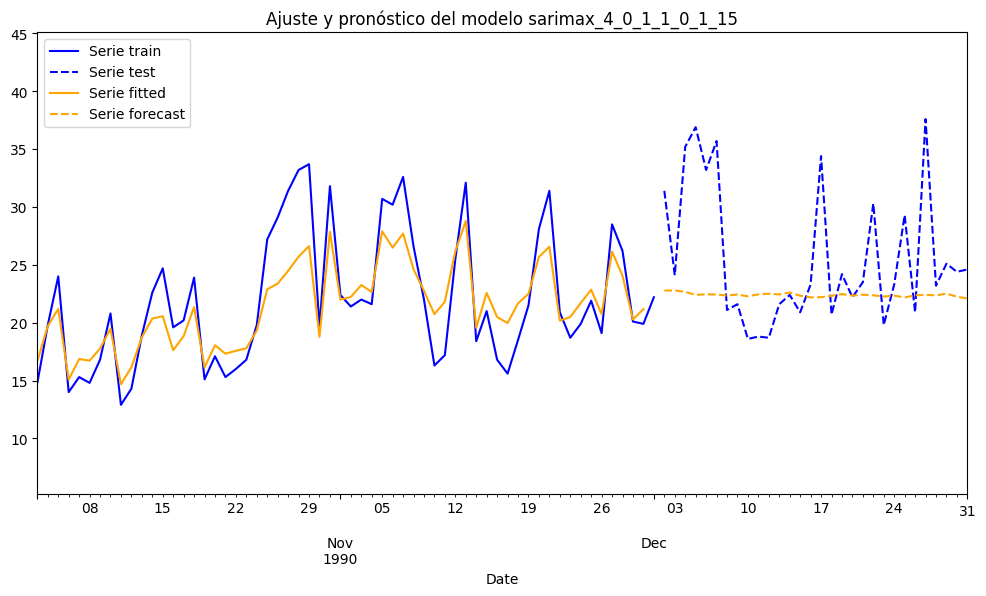

In [143]:
modelo = SARIMAX(df_temperature_train['Temperature'], order=(4,0,1), seasonal_order = (1,0,1,15))

# Calculo de metricas
resultado_modelos_arima, df_temperature, df_errores , modelos_arima = arima('sarimax_4_0_1_1_0_1_15', modelo, resultado_modelos_arima, df_temperature, df_metricas, modelos_arima)

                                 MAE        MSE      RMSE           AIC
sarimax_4_0_1_1_0_1_15      4.591615  43.643635  6.606333  20183.554428
sarimax_4_0_1_1_0_1_7       4.592276  43.779784  6.616629  20185.150433
sarimax_4_0_1_1_1_1_45      4.728953  44.509959  6.671578  20113.491596
sarimax_4_0_1_1_0_1_30      4.634159  44.560019  6.675329  20185.729362
sarimax_4_0_1_1_1_1_30      4.664762  44.636253  6.681037  20130.978832
arima_4_0_2                 4.637731  44.650831  6.682128  20177.365070
sarimax_4_0_1_1_1_1_7       4.639112  44.715874  6.686993  20175.635844
arima_4_0_4                 4.649368  44.737235  6.688590  20169.256536
sarimax_4_0_1_1_1_1_15      4.667874  44.843014  6.696493  20157.747900
arima_9_0_1                 4.665373  45.056665  6.712426  20172.949239
arima_4_0_1                 4.665003  45.094895  6.715273  20168.342272
arima_3_0_1                 4.672088  45.174594  6.721205  20176.873892
arima_5_0_1                 4.672715  45.199095  6.723027  20167

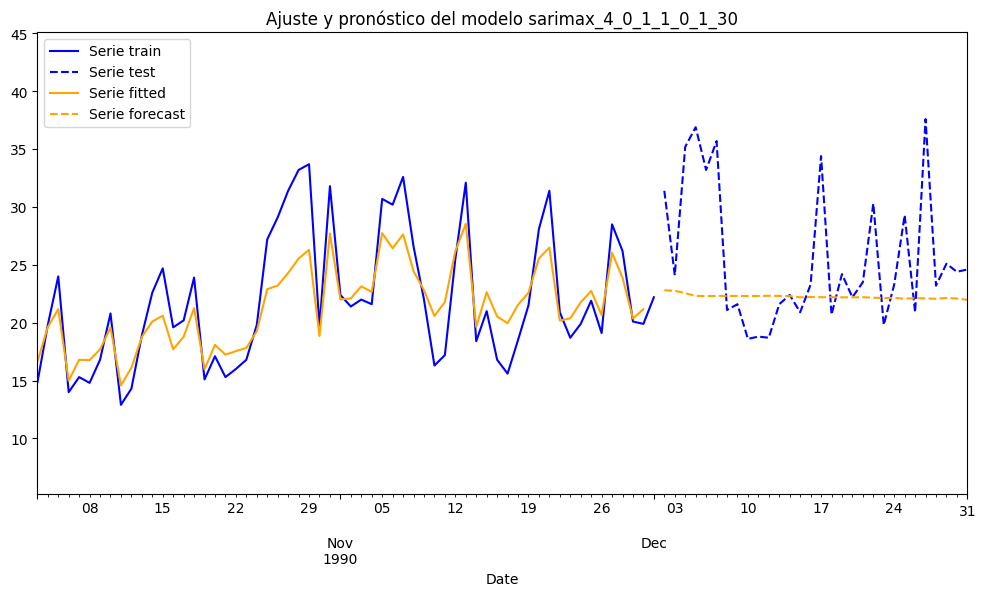

In [144]:
modelo = SARIMAX(df_temperature_train['Temperature'], order=(4,0,1), seasonal_order = (1,0,1,30))

# Calculo de metricas
resultado_modelos_arima, df_temperature, df_errores , modelos_arima = arima('sarimax_4_0_1_1_0_1_30', modelo, resultado_modelos_arima, df_temperature, df_metricas, modelos_arima)

                                 MAE        MSE      RMSE           AIC
sarimax_4_0_1_1_0_1_15      4.591615  43.643635  6.606333  20183.554428
sarimax_4_0_1_1_0_1_45      4.588509  43.728630  6.612763  20185.666282
sarimax_4_0_1_1_0_1_7       4.592276  43.779784  6.616629  20185.150433
sarimax_4_0_1_1_1_1_45      4.728953  44.509959  6.671578  20113.491596
sarimax_4_0_1_1_0_1_30      4.634159  44.560019  6.675329  20185.729362
sarimax_4_0_1_1_1_1_30      4.664762  44.636253  6.681037  20130.978832
arima_4_0_2                 4.637731  44.650831  6.682128  20177.365070
sarimax_4_0_1_1_1_1_7       4.639112  44.715874  6.686993  20175.635844
arima_4_0_4                 4.649368  44.737235  6.688590  20169.256536
sarimax_4_0_1_1_1_1_15      4.667874  44.843014  6.696493  20157.747900
arima_9_0_1                 4.665373  45.056665  6.712426  20172.949239
arima_4_0_1                 4.665003  45.094895  6.715273  20168.342272
arima_3_0_1                 4.672088  45.174594  6.721205  20176

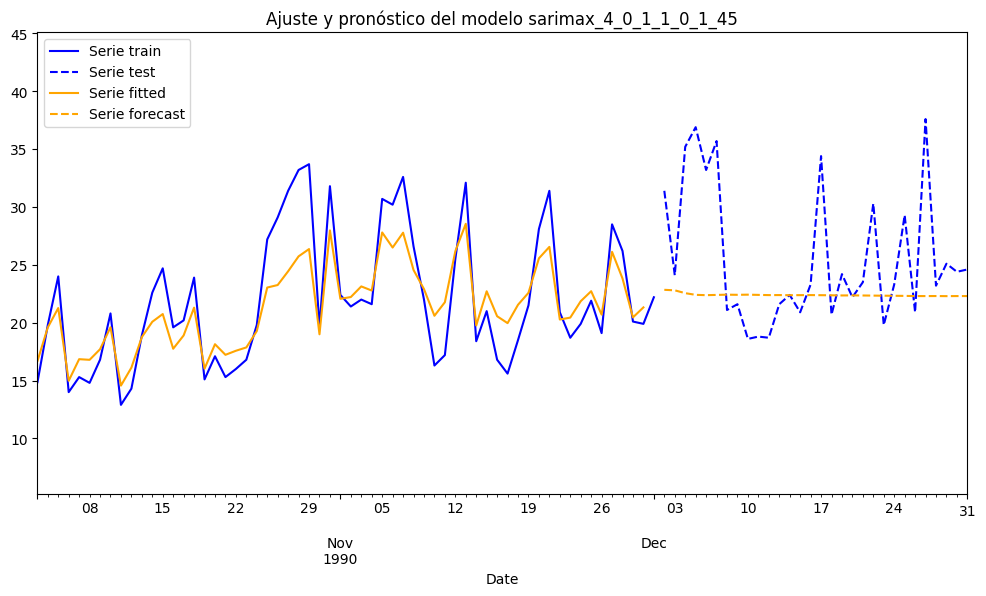

In [145]:
modelo = SARIMAX(df_temperature_train['Temperature'], order=(4,0,1), seasonal_order = (1,0,1,45))

# Calculo de metricas
resultado_modelos_arima, df_temperature, df_errores , modelos_arima = arima('sarimax_4_0_1_1_0_1_45', modelo, resultado_modelos_arima, df_temperature, df_metricas, modelos_arima)

c:\Users\juana\anaconda3\envs\AST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                 MAE        MSE      RMSE           AIC
sarimax_4_0_1_1_0_1_15      4.591615  43.643635  6.606333  20183.554428
sarimax_4_0_1_1_0_1_45      4.588509  43.728630  6.612763  20185.666282
sarimax_4_0_1_1_0_1_7       4.592276  43.779784  6.616629  20185.150433
sarimax_4_0_1_1_0_1_60      4.630592  44.487930  6.669927  20185.285639
sarimax_4_0_1_1_1_1_45      4.728953  44.509959  6.671578  20113.491596
sarimax_4_0_1_1_0_1_30      4.634159  44.560019  6.675329  20185.729362
sarimax_4_0_1_1_1_1_30      4.664762  44.636253  6.681037  20130.978832
arima_4_0_2                 4.637731  44.650831  6.682128  20177.365070
sarimax_4_0_1_1_1_1_7       4.639112  44.715874  6.686993  20175.635844
arima_4_0_4                 4.649368  44.737235  6.688590  20169.256536
sarimax_4_0_1_1_1_1_15      4.667874  44.843014  6.696493  20157.747900
arima_9_0_1                 4.665373  45.056665  6.712426  20172.949239
arima_4_0_1                 4.665003  45.094895  6.715273  20168

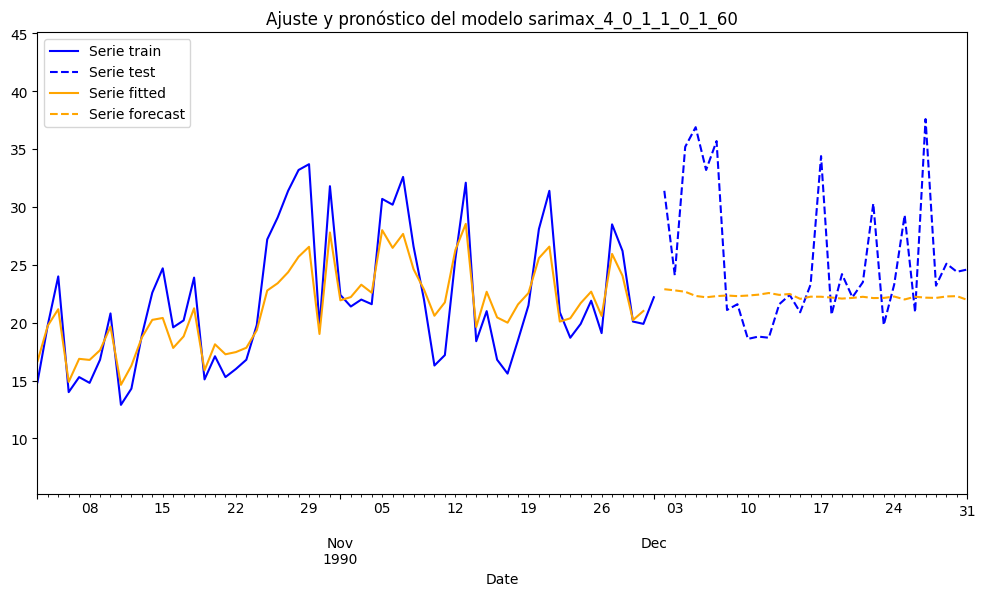

In [146]:
modelo = SARIMAX(df_temperature_train['Temperature'], order=(4,0,1), seasonal_order = (1,0,1,60))

# Calculo de metricas
resultado_modelos_arima, df_temperature, df_errores , modelos_arima = arima('sarimax_4_0_1_1_0_1_60', modelo, resultado_modelos_arima, df_temperature, df_metricas, modelos_arima)

                                 MAE        MSE      RMSE           AIC
arima_4_0_2                 4.637731  44.650831  6.682128  20177.365070
sarimax_4_0_1_1_1_1_7       4.639112  44.715874  6.686993  20175.635844
arima_4_0_4                 4.649368  44.737235  6.688590  20169.256536
arima_9_0_1                 4.665373  45.056665  6.712426  20172.949239
arima_4_0_1                 4.665003  45.094895  6.715273  20168.342272
arima_3_0_1                 4.672088  45.174594  6.721205  20176.873892
arima_5_0_1                 4.672715  45.199095  6.723027  20167.102862
arima_6_0_1                 4.676129  45.242637  6.726265  20169.003774
DES_trend_add               4.683962  45.740642  6.763183      0.000000
TES_trend_add_seasonal_add  5.197241  48.068017  6.933110      0.000000
SES                         4.804388  48.485323  6.963140      0.000000
DES_trend_mul               4.891813  49.127413  7.009095      0.000000
arima_10_0_0                4.902778  49.214503  7.015305  20231

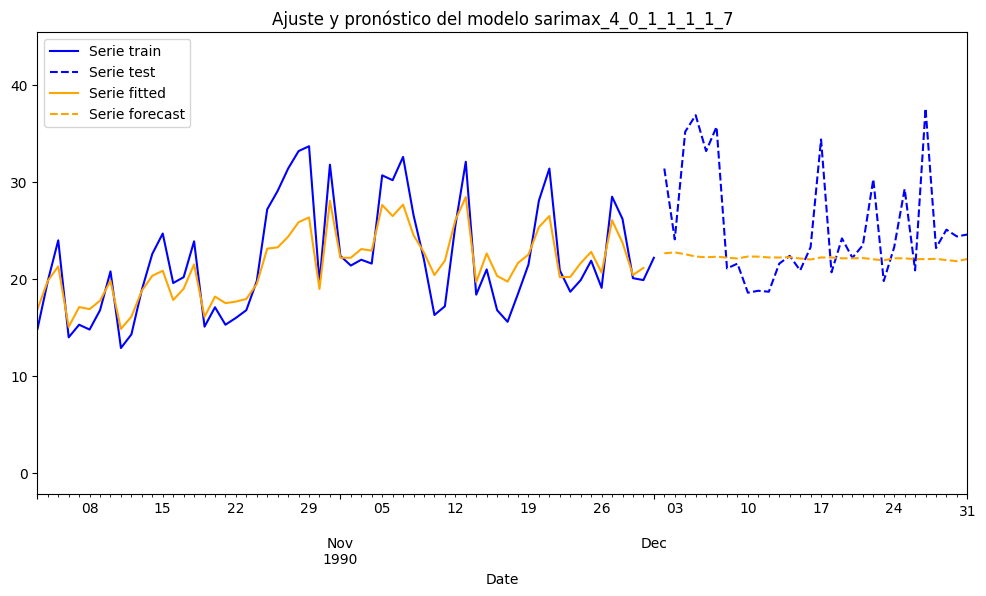

In [137]:
modelo = SARIMAX(df_temperature_train['Temperature'], order=(4,0,1), seasonal_order = (1,1,1,7))

# Calculo de metricas
resultado_modelos_arima, df_temperature, df_errores , modelos_arima = arima('sarimax_4_0_1_1_1_1_7', modelo, resultado_modelos_arima, df_temperature, df_metricas, modelos_arima)

                                 MAE        MSE      RMSE           AIC
arima_4_0_2                 4.637731  44.650831  6.682128  20177.365070
sarimax_4_0_1_1_1_1_7       4.639112  44.715874  6.686993  20175.635844
arima_4_0_4                 4.649368  44.737235  6.688590  20169.256536
sarimax_4_0_1_1_1_1_15      4.667874  44.843014  6.696493  20157.747900
arima_9_0_1                 4.665373  45.056665  6.712426  20172.949239
arima_4_0_1                 4.665003  45.094895  6.715273  20168.342272
arima_3_0_1                 4.672088  45.174594  6.721205  20176.873892
arima_5_0_1                 4.672715  45.199095  6.723027  20167.102862
arima_6_0_1                 4.676129  45.242637  6.726265  20169.003774
DES_trend_add               4.683962  45.740642  6.763183      0.000000
TES_trend_add_seasonal_add  5.197241  48.068017  6.933110      0.000000
SES                         4.804388  48.485323  6.963140      0.000000
DES_trend_mul               4.891813  49.127413  7.009095      0

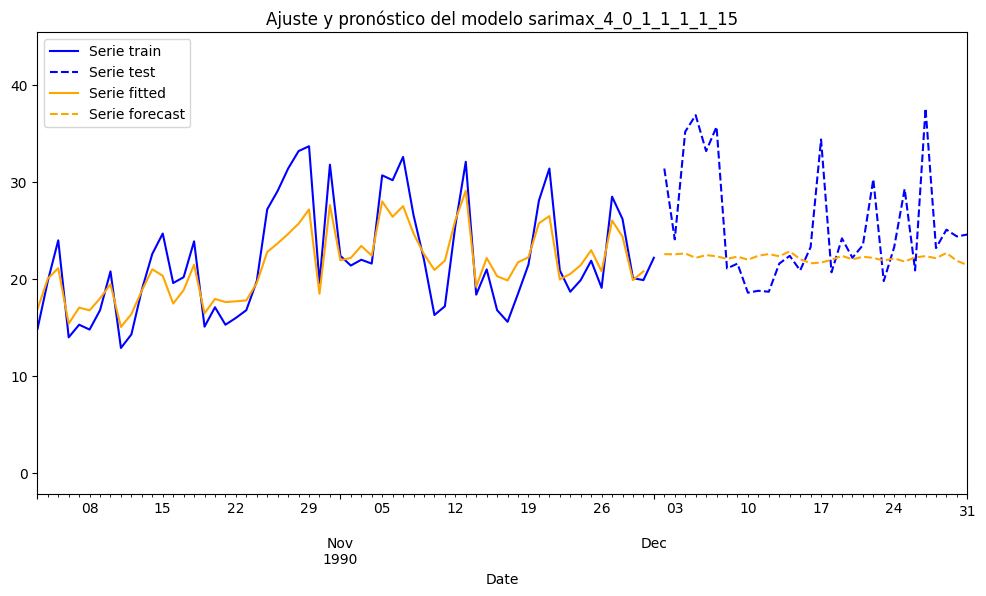

In [138]:
modelo = SARIMAX(df_temperature_train['Temperature'], order=(4,0,1), seasonal_order = (1,1,1,15))

# Calculo de metricas
resultado_modelos_arima, df_temperature, df_errores , modelos_arima = arima('sarimax_4_0_1_1_1_1_15', modelo, resultado_modelos_arima, df_temperature, df_metricas, modelos_arima)

                                 MAE        MSE      RMSE           AIC
sarimax_4_0_1_1_1_1_30      4.664762  44.636253  6.681037  20130.978832
arima_4_0_2                 4.637731  44.650831  6.682128  20177.365070
sarimax_4_0_1_1_1_1_7       4.639112  44.715874  6.686993  20175.635844
arima_4_0_4                 4.649368  44.737235  6.688590  20169.256536
sarimax_4_0_1_1_1_1_15      4.667874  44.843014  6.696493  20157.747900
arima_9_0_1                 4.665373  45.056665  6.712426  20172.949239
arima_4_0_1                 4.665003  45.094895  6.715273  20168.342272
arima_3_0_1                 4.672088  45.174594  6.721205  20176.873892
arima_5_0_1                 4.672715  45.199095  6.723027  20167.102862
arima_6_0_1                 4.676129  45.242637  6.726265  20169.003774
DES_trend_add               4.683962  45.740642  6.763183      0.000000
TES_trend_add_seasonal_add  5.197241  48.068017  6.933110      0.000000
SES                         4.804388  48.485323  6.963140      0

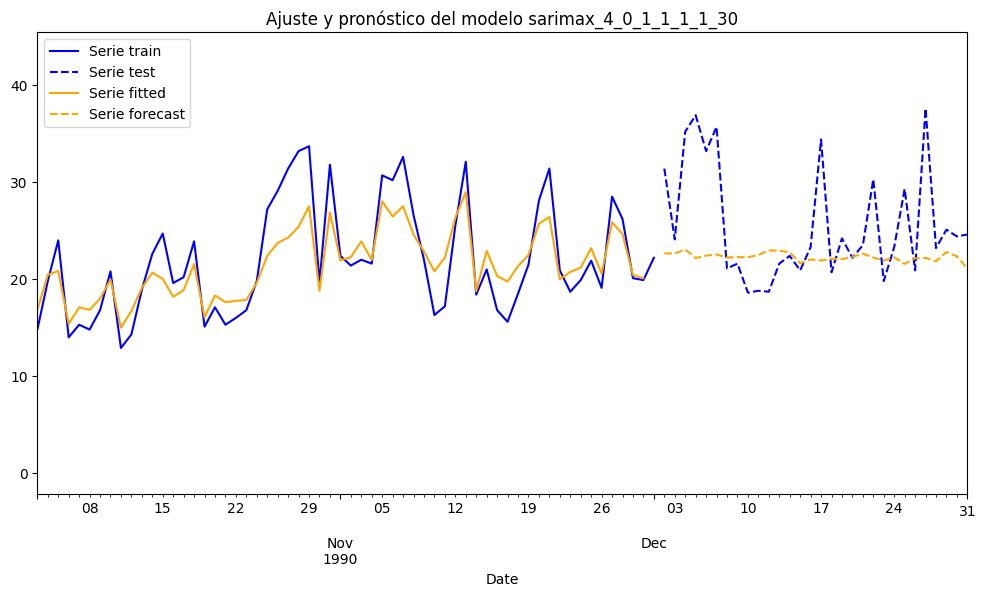

In [139]:
modelo = SARIMAX(df_temperature_train['Temperature'], order=(4,0,1), seasonal_order = (1,1,1,30))

# Calculo de metricas
resultado_modelos_arima, df_temperature, df_errores , modelos_arima = arima('sarimax_4_0_1_1_1_1_30', modelo, resultado_modelos_arima, df_temperature, df_metricas, modelos_arima)

                                 MAE        MSE      RMSE           AIC
sarimax_4_0_1_1_1_1_45      4.728953  44.509959  6.671578  20113.491596
sarimax_4_0_1_1_1_1_30      4.664762  44.636253  6.681037  20130.978832
arima_4_0_2                 4.637731  44.650831  6.682128  20177.365070
sarimax_4_0_1_1_1_1_7       4.639112  44.715874  6.686993  20175.635844
arima_4_0_4                 4.649368  44.737235  6.688590  20169.256536
sarimax_4_0_1_1_1_1_15      4.667874  44.843014  6.696493  20157.747900
arima_9_0_1                 4.665373  45.056665  6.712426  20172.949239
arima_4_0_1                 4.665003  45.094895  6.715273  20168.342272
arima_3_0_1                 4.672088  45.174594  6.721205  20176.873892
arima_5_0_1                 4.672715  45.199095  6.723027  20167.102862
arima_6_0_1                 4.676129  45.242637  6.726265  20169.003774
DES_trend_add               4.683962  45.740642  6.763183      0.000000
TES_trend_add_seasonal_add  5.197241  48.068017  6.933110      0

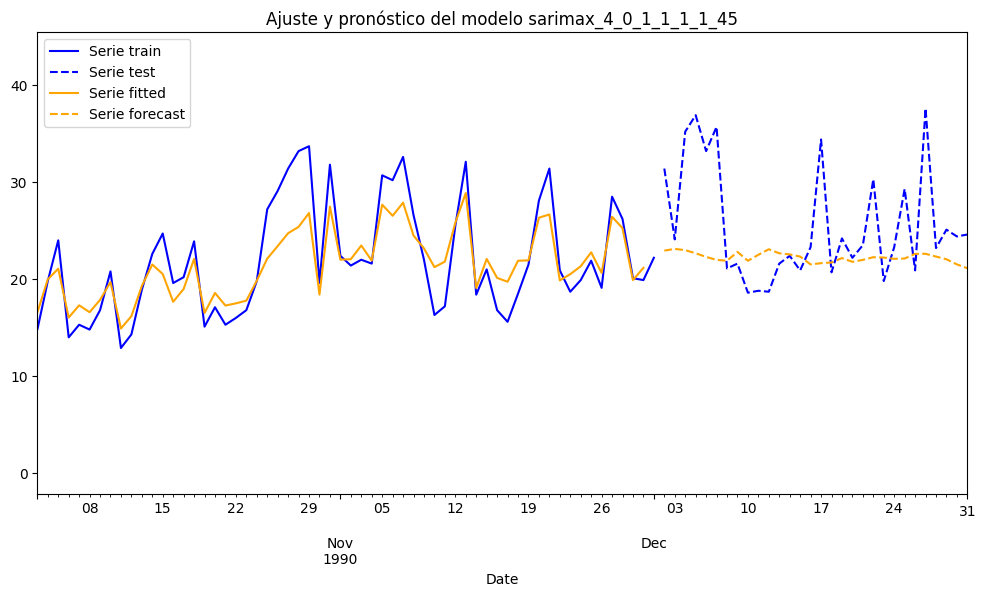

In [140]:
modelo = SARIMAX(df_temperature_train['Temperature'], order=(4,0,1), seasonal_order = (1,1,1,45))

# Calculo de metricas
resultado_modelos_arima, df_temperature, df_errores , modelos_arima = arima('sarimax_4_0_1_1_1_1_45', modelo, resultado_modelos_arima, df_temperature, df_metricas, modelos_arima)

                                 MAE        MSE      RMSE           AIC
sarimax_4_0_1_1_1_1_45      4.728953  44.509959  6.671578  20113.491596
sarimax_4_0_1_1_1_1_30      4.664762  44.636253  6.681037  20130.978832
arima_4_0_2                 4.637731  44.650831  6.682128  20177.365070
sarimax_4_0_1_1_1_1_7       4.639112  44.715874  6.686993  20175.635844
arima_4_0_4                 4.649368  44.737235  6.688590  20169.256536
sarimax_4_0_1_1_1_1_15      4.667874  44.843014  6.696493  20157.747900
arima_9_0_1                 4.665373  45.056665  6.712426  20172.949239
arima_4_0_1                 4.665003  45.094895  6.715273  20168.342272
arima_3_0_1                 4.672088  45.174594  6.721205  20176.873892
arima_5_0_1                 4.672715  45.199095  6.723027  20167.102862
arima_6_0_1                 4.676129  45.242637  6.726265  20169.003774
sarimax_4_0_1_1_1_1_60      4.709222  45.335294  6.733149  20067.911720
DES_trend_add               4.683962  45.740642  6.763183      0

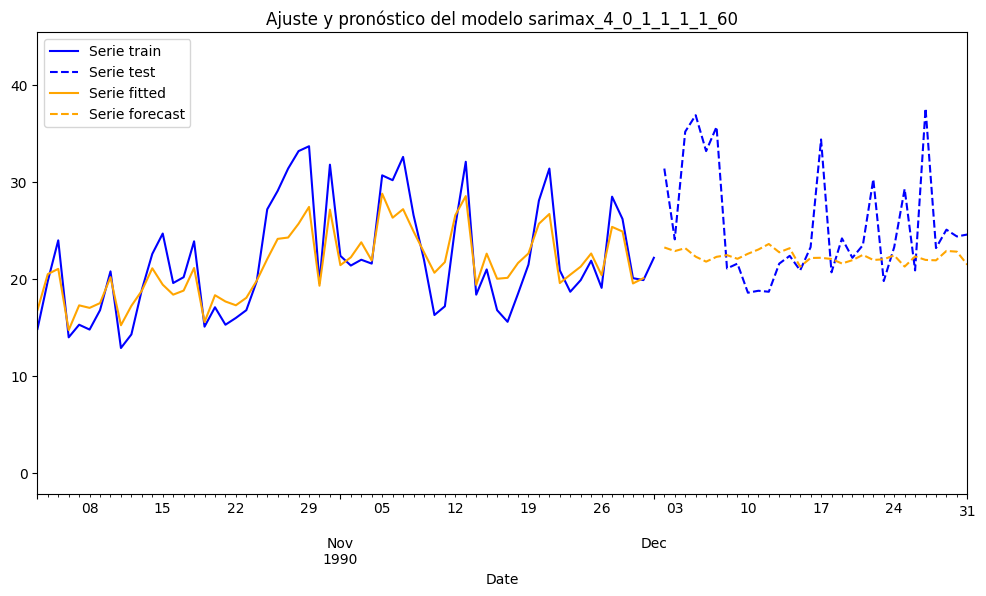

In [141]:
modelo = SARIMAX(df_temperature_train['Temperature'], order=(4,0,1), seasonal_order = (1,1,1,60))

# Calculo de metricas
resultado_modelos_arima, df_temperature, df_errores , modelos_arima = arima('sarimax_4_0_1_1_1_1_60', modelo, resultado_modelos_arima, df_temperature, df_metricas, modelos_arima)

## Modelo Auto Arima

In [ ]:
modelo_auto = auto_arima(
    df_temperature_train['Temperature'],
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=0,                   
    seasonal=True,
    m=7,                  
    start_P=0, max_P=3,
    start_Q=0, max_Q=3,
    D=1,                   
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print(modelo_auto.summary())

c:\Users\juana\anaconda3\envs\AST\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic


c:\Users\juana\anaconda3\envs\AST\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,1,0)[15] intercept   : AIC=23378.897, Time=4.99 sec


c:\Users\juana\anaconda3\envs\AST\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,0)[15] intercept   : AIC=21540.099, Time=10.65 sec


c:\Users\juana\anaconda3\envs\AST\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,1,1)[15] intercept   : AIC=21256.438, Time=7.54 sec


c:\Users\juana\anaconda3\envs\AST\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,1,0)[15]             : AIC=23377.016, Time=35.64 sec


c:\Users\juana\anaconda3\envs\AST\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,1,0)[15] intercept   : AIC=22479.331, Time=3.90 sec


c:\Users\juana\anaconda3\envs\AST\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,1,1)[15] intercept   : AIC=21252.700, Time=15.64 sec


c:\Users\juana\anaconda3\envs\AST\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,1,0)[15] intercept   : AIC=21589.769, Time=13.85 sec


c:\Users\juana\anaconda3\envs\AST\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(2,1,1)[15] intercept   : AIC=21252.694, Time=58.90 sec


c:\Users\juana\anaconda3\envs\AST\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(2,1,0)[15] intercept   : AIC=21320.739, Time=29.94 sec


c:\Users\juana\anaconda3\envs\AST\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(3,1,1)[15] intercept   : AIC=inf, Time=286.38 sec


c:\Users\juana\anaconda3\envs\AST\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(2,1,2)[15] intercept   : AIC=21251.593, Time=157.24 sec


c:\Users\juana\anaconda3\envs\AST\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,1,2)[15] intercept   : AIC=21254.149, Time=81.92 sec


c:\Users\juana\anaconda3\envs\AST\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(3,1,2)[15] intercept   : AIC=inf, Time=328.16 sec


c:\Users\juana\anaconda3\envs\AST\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(2,1,3)[15] intercept   : AIC=21253.055, Time=172.17 sec


c:\Users\juana\anaconda3\envs\AST\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


MemoryError: Unable to allocate 106. MiB for an array with shape (62, 62, 3623) and data type float64

## Modelo RNN-LSTM

### Escalamiento de los datos

In [25]:
scaler = MinMaxScaler()

In [26]:
# Se ajusta el escalador con los datos de entrenamiento
scaler.fit(df_temperature_train[['Temperature']])

MinMaxScaler()

In [27]:
df_temperature_scaled_train = scaler.transform(df_temperature_train[['Temperature']])
df_temperature_scaled_test = scaler.transform(df_temperature_test[['Temperature']])

### Generacion de series de tiempo

In [32]:
# Se define el generador
n_input = 15
n_features = 1
ytemperature_generator = TimeseriesGenerator(df_temperature_scaled_train, df_temperature_scaled_train, length=n_input, batch_size=1)

### Creacion del modelo

In [33]:
# Definición del modelo
temperature_model = Sequential()
temperature_model.add(Input(shape=(n_input, n_features)))
temperature_model.add(LSTM(100, activation='relu'))
temperature_model.add(Dense(1))
temperature_model.compile(optimizer='adam', loss='mse')

In [34]:
temperature_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Ajuste del modelo
temperature_model.fit(ytemperature_generator,epochs=50)

Epoch 1/50
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - loss: 0.0181
Epoch 2/50
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - loss: 0.0129
Epoch 3/50
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 34s 10ms/step - loss: 0.0119
Epoch 4/50
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 34s 9ms/step - loss: 0.0116
Epoch 5/50
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - loss: 0.0122
Epoch 6/50
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 34s 9ms/step - loss: 0.0119
Epoch 7/50
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 34s 10ms/step - loss: 0.0111
Epoch 8/50
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 34s 9ms/step - loss: 0.0116
Epoch 9/50
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 34s 9ms/step - loss: 0.0117
Epoch 10/50
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 31s 9ms/step - loss: 0.0113
Epoch 11/50
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 33s 9ms/step - loss: 0.0120
Epoch 12/50
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - loss: 0.0110
Epoch 13/50
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - loss: 0.0114
Epoch 14/50
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - loss: 0.0106
Epoch 15/5

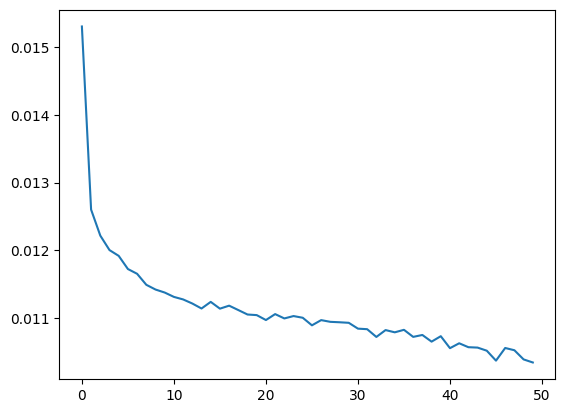

In [36]:
# Ploteo de loss
plt.plot(range(len(temperature_model.history.history['loss'])),temperature_model.history.history['loss'])

### Evaluacion del modelo

In [40]:
temperature_test_predictions = []

temperature_first_eval_batch = df_temperature_scaled_train[-n_input:]
temperature_current_batch = temperature_first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(df_temperature_test[['Temperature']])):
    
    # Se obtiene la predicción 1 paso hacia adelante
    temperature_current_pred = temperature_model.predict(temperature_current_batch)[0]
    
    # Se guarda la predicción
    temperature_test_predictions.append(temperature_current_pred) 
    
    # Se actualiza el lote
    temperature_current_batch = np.append(temperature_current_batch[:,1:,:],[[temperature_current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

In [41]:
# Volvemos los datos a su escala original
true_temperature_test_predictions = scaler.inverse_transform(temperature_test_predictions)

In [42]:
# Guardamos las predicciones
df_temperature_test.loc[:,'Predictions'] = true_temperature_test_predictions

<Axes: xlabel='Date'>

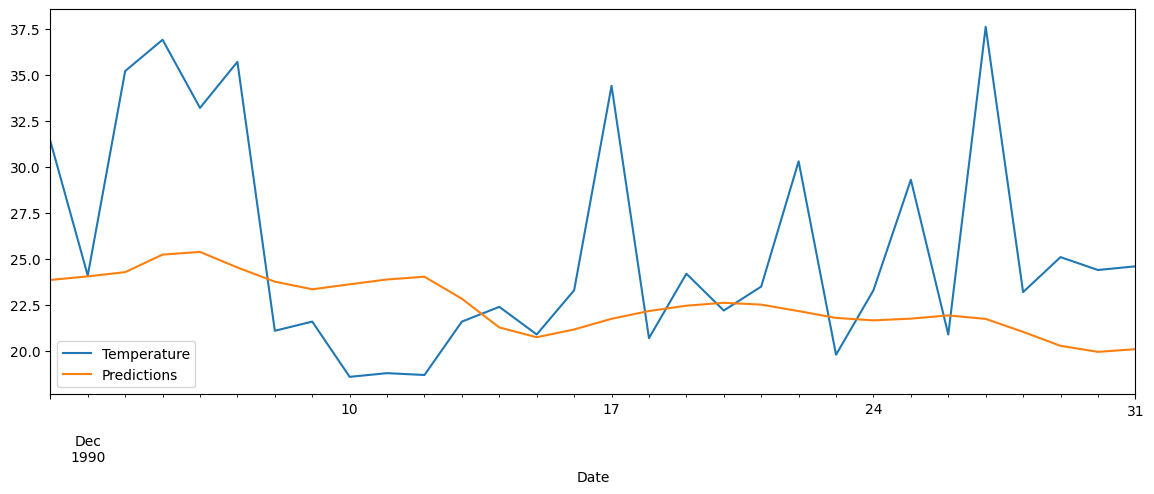

In [43]:
df_temperature_test[['Temperature','Predictions']].plot(figsize=(14,5))

In [ ]:
# Calculo de los errores
errores = evaluar_modelo(df_temperature_test[['Temperature']], df_temperature_test[['Predictions']], nombre_modelo="LSTM")

# Guardado de los errores en df_metrics
df_metricas.loc['LSTM'] = errores

print(df_metricas.sort_values('RMSE'))

                                 MAE        MSE      RMSE           AIC
LSTM                        4.888561  41.231164  6.421150           NaN
sarimax_4_0_1_1_0_1_15      4.591615  43.643635  6.606333  20183.554428
sarimax_4_0_1_1_0_1_45      4.588509  43.728630  6.612763  20185.666282
sarimax_4_0_1_1_0_1_7       4.592276  43.779784  6.616629  20185.150433
sarimax_4_0_1_1_0_1_60      4.630592  44.487930  6.669927  20185.285639
sarimax_4_0_1_1_1_1_45      4.728953  44.509959  6.671578  20113.491596
sarimax_4_0_1_1_0_1_30      4.634159  44.560019  6.675329  20185.729362
sarimax_4_0_1_1_1_1_30      4.664762  44.636253  6.681037  20130.978832
arima_4_0_2                 4.637731  44.650831  6.682128  20177.365070
sarimax_4_0_1_1_1_1_7       4.639112  44.715874  6.686993  20175.635844
arima_4_0_4                 4.649368  44.737235  6.688590  20169.256536
sarimax_4_0_1_1_1_1_15      4.667874  44.843014  6.696493  20157.747900
arima_9_0_1                 4.665373  45.056665  6.712426  20172

In [44]:
# Inicializamos
temperature_train_predictions = []

# Primer batch de evaluación
temperature_current_batch = df_temperature_scaled_train[:n_input].reshape((1, n_input, n_features))

# Generar predicciones para cada punto del entrenamiento a partir del input desfasado
for i in range(n_input, len(df_temperature_scaled_train)):
    # Predicción
    temperature_current_pred = temperature_model.predict(temperature_current_batch)[0]
    temperature_train_predictions.append(temperature_current_pred)

    # Actualización del lote (avanza un paso)
    temperature_current_batch = np.append(temperature_current_batch[:, 1:, :], [[df_temperature_scaled_train[i]]], axis=1)

# Inversión de la escala
true_temperature_train_predictions = scaler.inverse_transform(temperature_train_predictions)

# Crear un índice alineado con las predicciones
train_pred_index = df_temperature_train.index[n_input:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

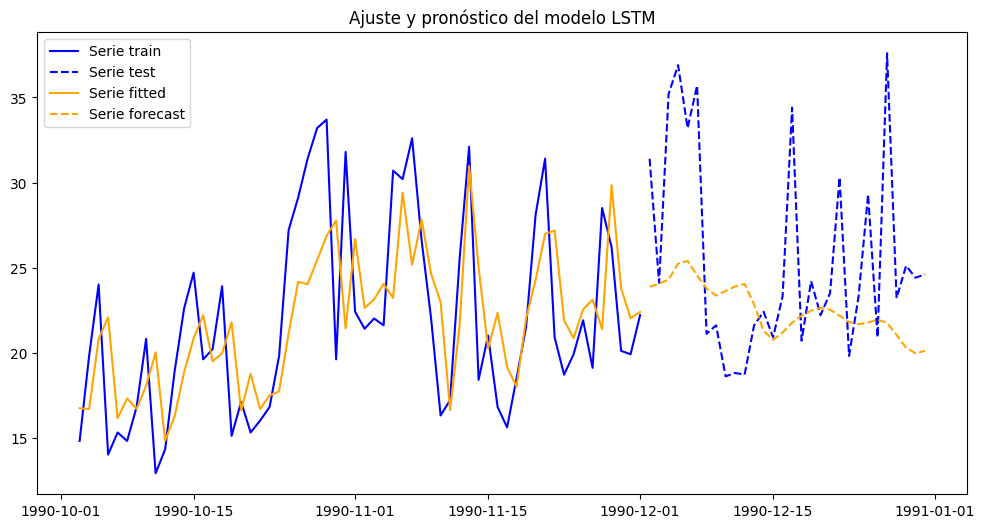

In [46]:
plt.figure(figsize=(12, 6))

# Últimos 60 registros de entrenamiento
plt.plot(df_temperature_train.index[-60:], df_temperature_train['Temperature'].iloc[-60:], label='Serie train', color='b')

# Test completo
plt.plot(df_temperature_test.index, df_temperature_test['Temperature'], label='Serie test', color='b', linestyle='--')

# Serie ajustada (últimos 60 registros de train_pred_index)
plt.plot(train_pred_index[-60:], true_temperature_train_predictions[-60:], label='Serie fitted', color='orange')

# Pronóstico (forecast)
plt.plot(df_temperature_test.index, true_temperature_test_predictions, label='Serie forecast', color='orange', linestyle='--')

plt.title('Ajuste y pronóstico del modelo LSTM')
plt.legend()
plt.show()